# Pathfinding Exploration

- DFS
- BFS
- IDDFS (removed completely)
- A-star

In [242]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output, display

from utils.search import bfs, dfs, dfs_heuristic, greedy_bfs, a_star
from utils.graph import Graph
from utils.plots import plot_grid, plot_path, bar_chart_performance

## A simple example of N = 1

Also showing the different types of grids that can be used.

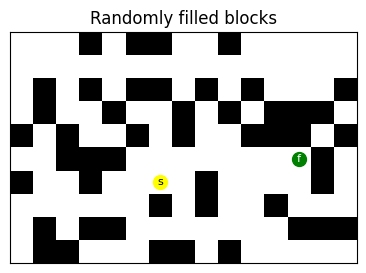

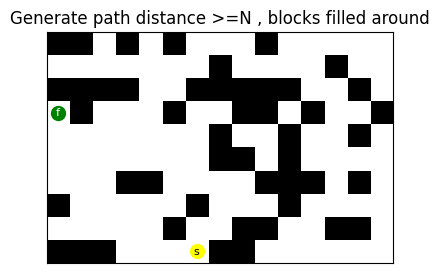

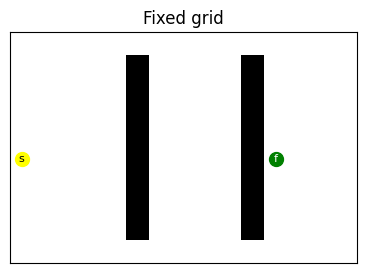

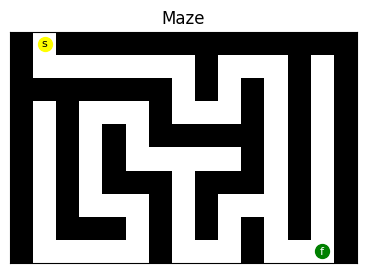

In [2]:
percent_blockage = 0.4

graph = Graph(rows=10, cols=15)


graph.generate_grid(grid_type="random", percent_blocked=percent_blockage)
plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.title("Randomly filled blocks")
plt.show()

graph.generate_grid(grid_type="random-1", percent_blocked=percent_blockage)
plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.title("Generate path distance >=N , blocks filled around")
plt.show()

graph.generate_grid(grid_type="fixed", variant=2)
plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.title("Fixed grid")
plt.show()

graph.generate_grid(grid_type="maze")
plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.title("Maze")
plt.show()

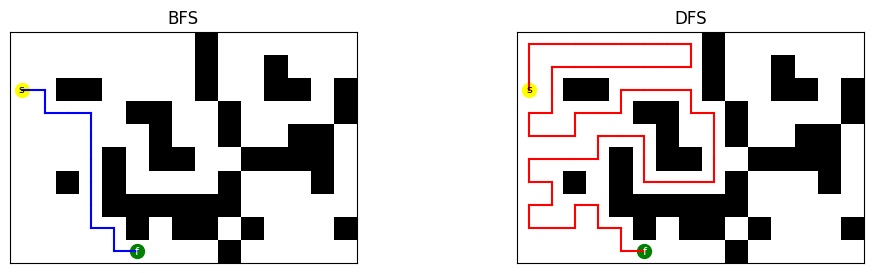

BFS:
Time: 0.0001900196075439453 (s)
# Iteractions: 64
Path length: 12

DFS:
Time: 0.0001380443572998047 (s)
# Iteractions: 73
Path length: 58


In [3]:
graph.generate_grid(grid_type="random-1", percent_blocked=percent_blockage)

bfs_path, bfs_complexity = graph.search(bfs)
dfs_path, dfs_complexity = graph.search(dfs)

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], dfs_path, c='red',label='DFS')

plt.show()

print("BFS:")
print("Time:", bfs_complexity["time"], "(s)")
print("# Iteractions:", bfs_complexity["iterations"])
print("Path length:", bfs_complexity["length"])

print()
print("DFS:")
print("Time:", dfs_complexity["time"], "(s)")
print("# Iteractions:", dfs_complexity["iterations"])
print("Path length:", dfs_complexity["length"])

### Let's see this interactively

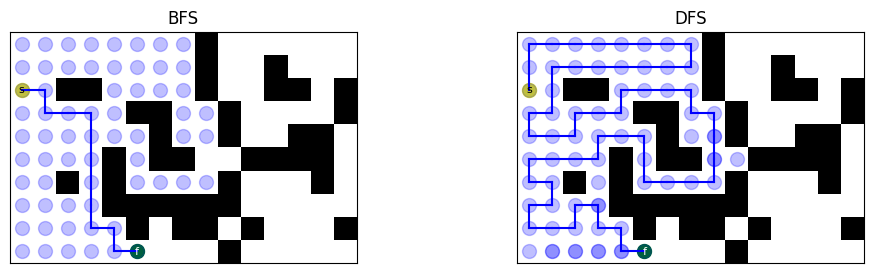

In [4]:
bfs_generator = graph.search_generator(bfs)
dfs_generator = graph.search_generator(dfs)

generators = [bfs_generator, dfs_generator]

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("DFS")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

## Let's do this many times and compare.

Important to note that as the `percent_blockage` gets to a certain point, there tends to become less and less available paths (and neighbors), so we see some convergence between methods. I'll stop it by a certain point, as we're guaranteeing an existing path, so going beyond a certain `percent_blockage` becomes redundant.

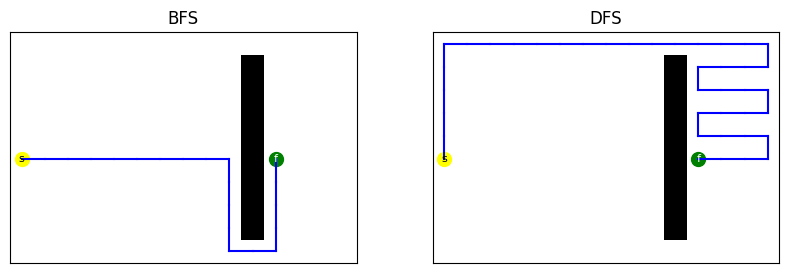

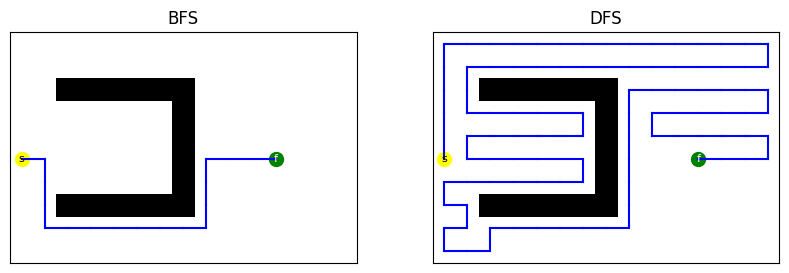

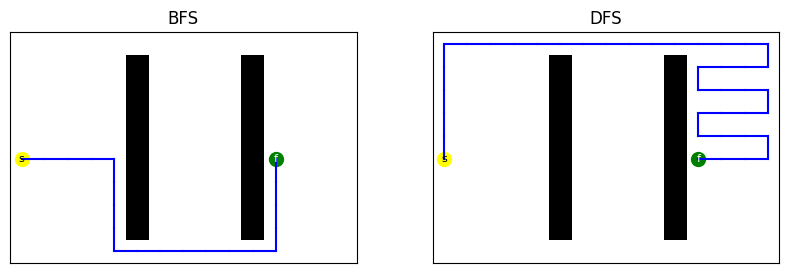

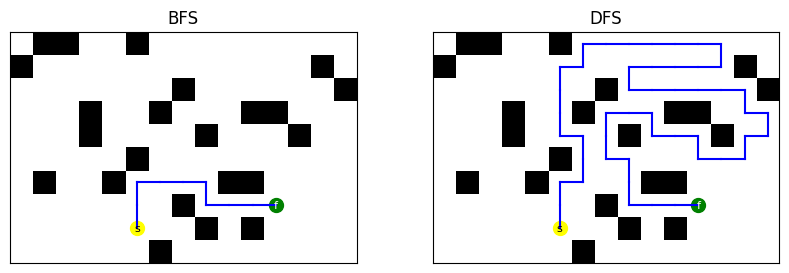

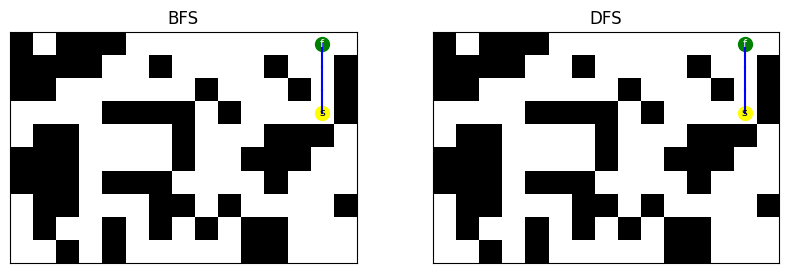

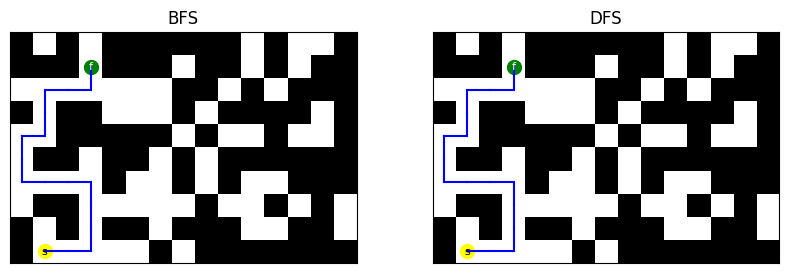

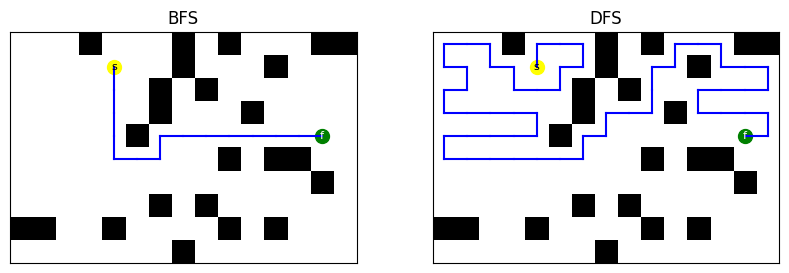

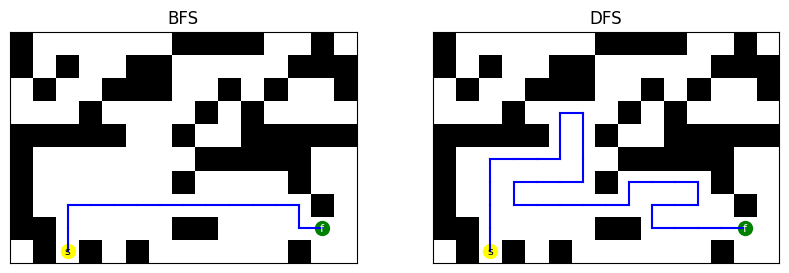

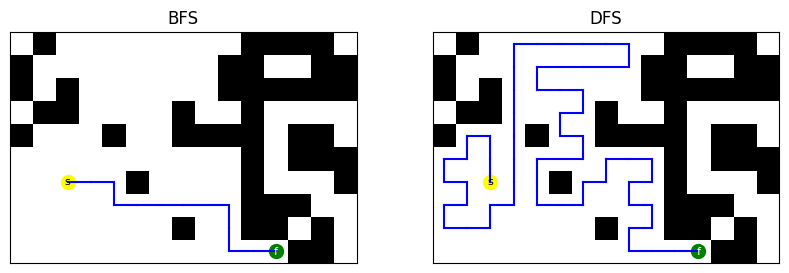

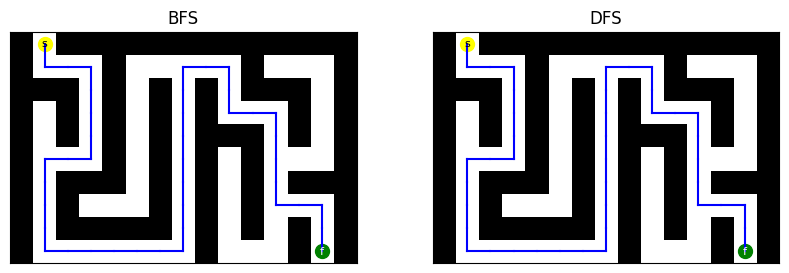

In [86]:
n = 1_000

datas = []
percent_blockages = [0.2, 0.4, 0.6]

graph = Graph(rows=10, cols=15)

to_search = [
    {
        "name": "bfs",
        "label": "BFS",
        "fct": bfs,
    },
    {
        "name": "dfs",
        "label": "DFS",
        "fct": dfs,
    },
]

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
    }

    graph.generate_grid(grid_type="fixed", variant=variant)

    _, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

    for i, search in enumerate(to_search):
        fct = search["fct"]
        name = search["name"]
        label = search["label"]
        path, complexity = graph.search(search["fct"])

        data[name] = {}

        data[name]["time"] = complexity["time"]
        data[name]["iterations"] = complexity["iterations"]
        data[name]["length"] = complexity["length"]

        plot_path(axes[i], path, c='blue',label=label)

    plt.show()

    datas.append(data)

for grid_type in ["random", "random-1"]:
    for percent in percent_blockages:
        data = {
            "percent": percent,
            "type": grid_type,
        }
        for i in range(n):
            graph.generate_grid(grid_type=grid_type, percent_blocked=percent)

            if i == n - 1:
                _, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
                plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

            for j, search in enumerate(to_search):
                fct = search["fct"]
                name = search["name"]
                label = search["label"]
                path, complexity = graph.search(search["fct"])

                if name not in data:
                    data[name] = {"time": 0, "iterations": 0, "length": 0}

                data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
                data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
                data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

                if i == n - 1:
                    plot_path(axes[j], path, c='blue',label=label)
        plt.show()
        datas.append(data)

# Maze grids
data = {
    "percent": 0,
    "type": "maze",
}
for i in range(n):
    graph.generate_grid(grid_type="maze")

    if i == n - 1:
        _, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
        plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

    for j, search in enumerate(to_search):
        fct = search["fct"]
        name = search["name"]
        label = search["label"]
        path, complexity = graph.search(search["fct"])

        if complexity["time"] is None: break

        if name not in data:
            data[name] = {"time": 0, "iterations": 0, "length": 0}

        data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
        data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
        data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

        if i == n - 1:
            plot_path(axes[j], path, c='blue',label=label)
plt.show()
datas.append(data)


In [87]:
data_df = {"percent": [], "type": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    for k in ["time", "iterations", "length"]:
        for value in to_search:
            t = value["name"]
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [88]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time            iterations                length  \
                       bfs       dfs         bfs        dfs        bfs   
percent type                                                             
0.0     fixed_0   0.000357  0.000075  123.000000   40.00000  19.000000   
        fixed_1   0.000213  0.000130  111.000000  102.00000  17.000000   
        fixed_2   0.000232  0.000057  115.000000   40.00000  19.000000   
0.2     random    0.000108  0.000087   62.022000   78.94000   9.388000   
0.4     random    0.000073  0.000065   42.482000   58.58300  13.399000   
0.6     random    0.000043  0.000032   24.736000   29.20500  14.323000   
0.2     random-1  0.000167  0.000086  100.375000   77.06600  12.302000   
0.4     random-1  0.000130  0.000079   76.644000   69.02700  12.639000   
0.6     random-1  0.000097  0.000056   55.717000   48.33100  13.445000   
0.0     maze      0.000084  0.000084   48.710412   72.14458  36.349381   

                              
                         dfs  
percent type                  
0.0     fixed_0    39.000000  
        fixed_1   101.000000  
        fixed_2    39.000000  
0.2     random     44.800000  
0.4     random     20.697000  
0.6     random     15.727000  
0.2     random-1   55.180000  
0.4     random-1   35.251000  
0.6     random-1   26.577000  
0.0     maze       36.349381

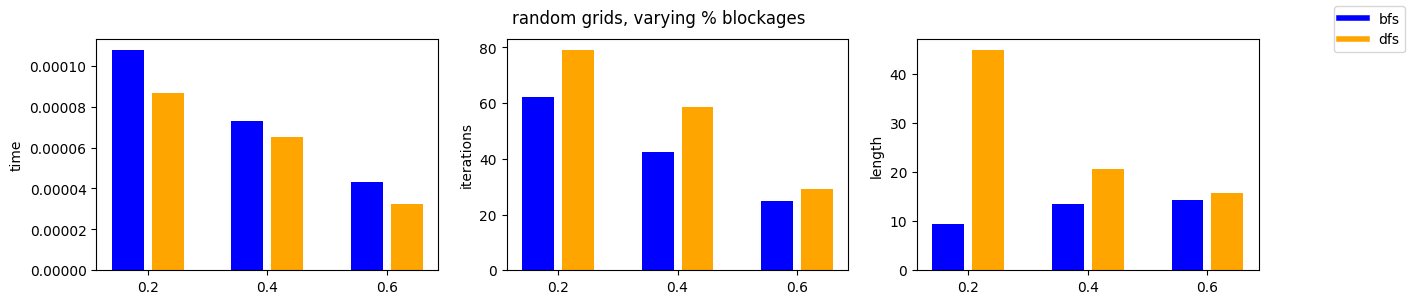

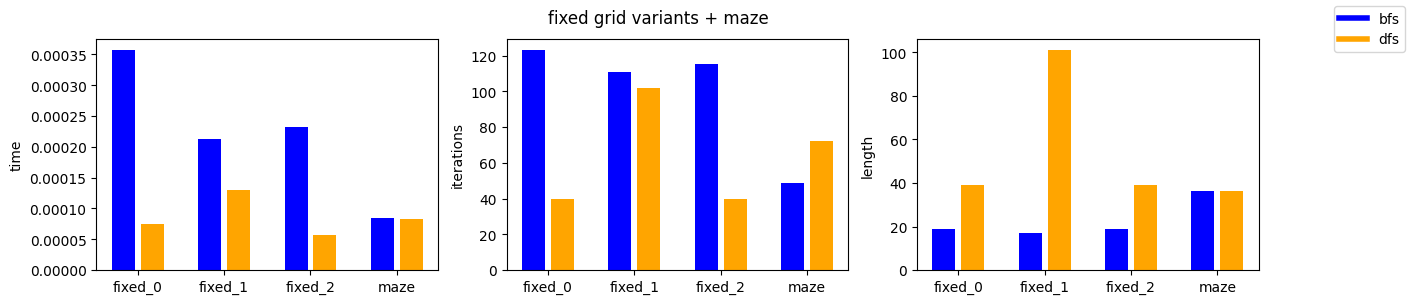

In [208]:
colors = {
    "bfs": "blue",
    "dfs": "orange",
}

partition = df.xs("random", level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("random grids (method 1), varying % blockages")
plt.show()

partition = df.xs("random-1", level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("random grids (method 2), varying % blockages")
plt.show()

partition = df.xs(0, level=0)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("fixed grid variants + maze")
plt.show()


# Adding heuristics to search

Right now selecting a neighbor has equivalent "cost". We know where the starting + end locations are located, so can we use this information?

Rather than BFS / DFS randomly traversing the space, let's intro some heuristics.

Doing this will also introduce a new Data Structure `Priority Queue`. Rather than simply using a queue, we can sort it based on some priority given a heuristic.

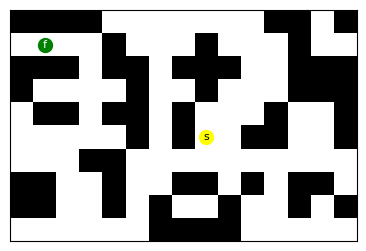

In [59]:
percent_blockage = 0.4
graph = Graph(rows=10, cols=15)
graph.generate_grid(grid_type="random", percent_blocked=percent_blockage)

plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.show()

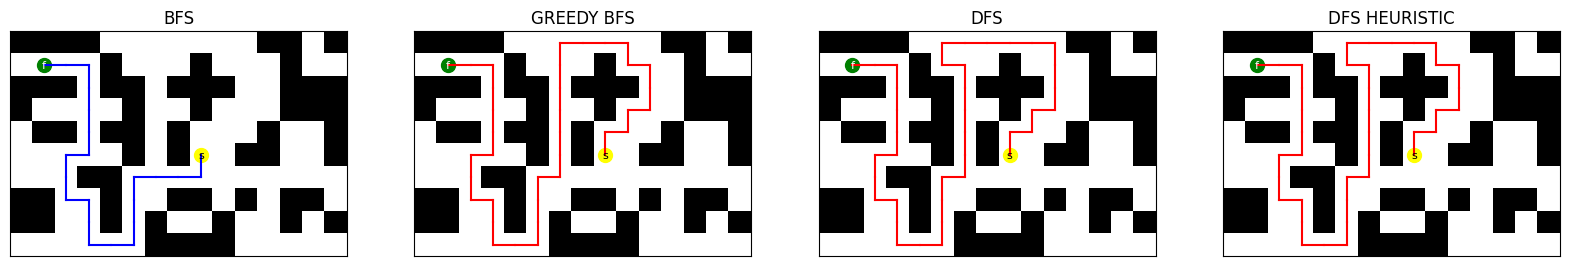

BFS:
Time: 0.000225067138671875 (s)
# Iteractions: 84
Path length: 21

GREEDY BFS:
Time: 0.0001659393310546875 (s)
# Iteractions: 54
Path length: 35

DFS:
Time: 0.00010704994201660156 (s)
# Iteractions: 56
Path length: 37

DFS HEURISTIC:
Time: 0.00014209747314453125 (s)
# Iteractions: 56
Path length: 37


In [60]:
bfs_path, bfs_complexity = graph.search(bfs)
greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
dfs_path, dfs_complexity = graph.search(dfs)
dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)


_, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], greedy_bfs_path, c='red',label='GREEDY BFS')
plot_path(axes[2], dfs_path, c='red',label='DFS')
plot_path(axes[3], dfs_heur_path, c='red',label='DFS HEURISTIC')

plt.show()


print("BFS:")
print("Time:", bfs_complexity["time"], "(s)")
print("# Iteractions:", bfs_complexity["iterations"])
print("Path length:", bfs_complexity["length"])

print()
print("GREEDY BFS:")
print("Time:", greedy_bfs_complexity["time"], "(s)")
print("# Iteractions:", greedy_bfs_complexity["iterations"])
print("Path length:", greedy_bfs_complexity["length"])

print()
print("DFS:")
print("Time:", dfs_complexity["time"], "(s)")
print("# Iteractions:", dfs_complexity["iterations"])
print("Path length:", dfs_complexity["length"])

print()
print("DFS HEURISTIC:")
print("Time:", dfs_heur_complexity["time"], "(s)")
print("# Iteractions:", dfs_heur_complexity["iterations"])
print("Path length:", dfs_heur_complexity["length"])

### Again, let's see this interactively to how the heuristic behaves

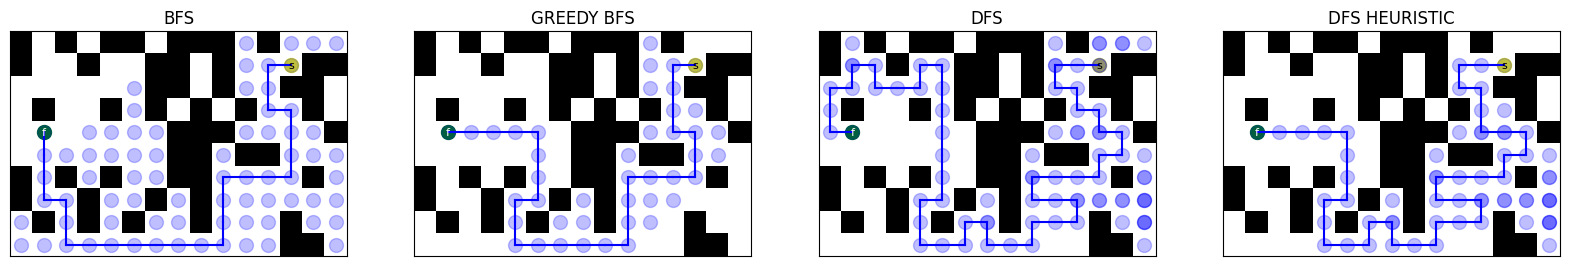

In [28]:
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)

generators = [bfs_generator, greedy_bfs_generator, dfs_generator, dfs_heur_generator]

_, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("GREEDY BFS")
    axes[2].set_title("DFS")
    axes[3].set_title("DFS HEURISTIC")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

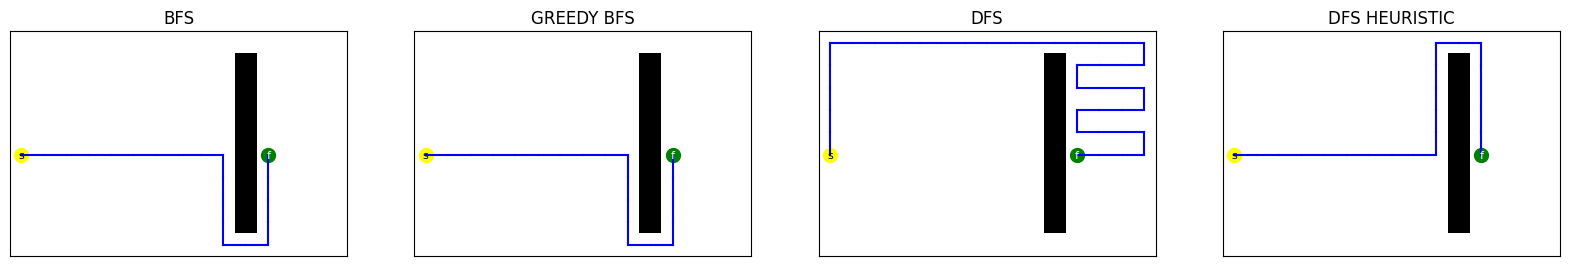

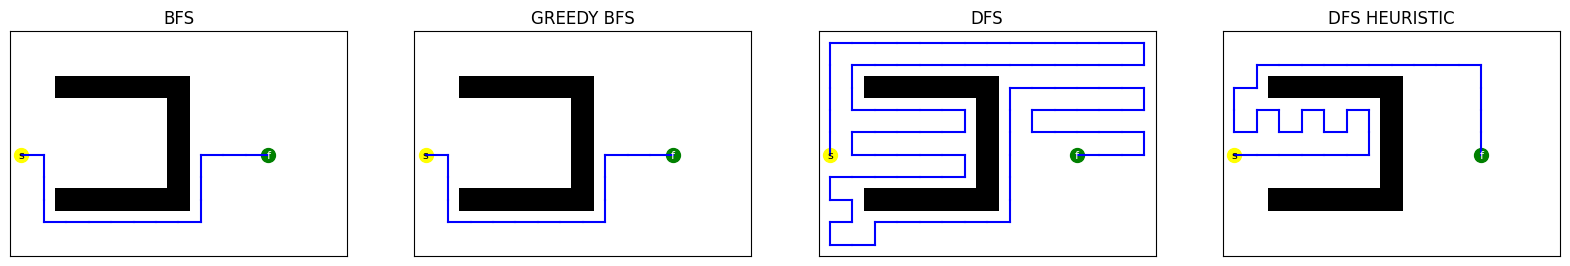

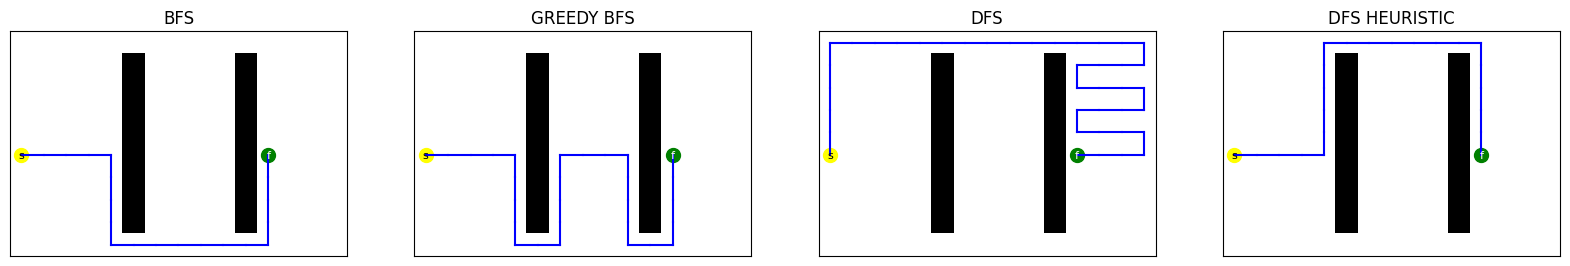

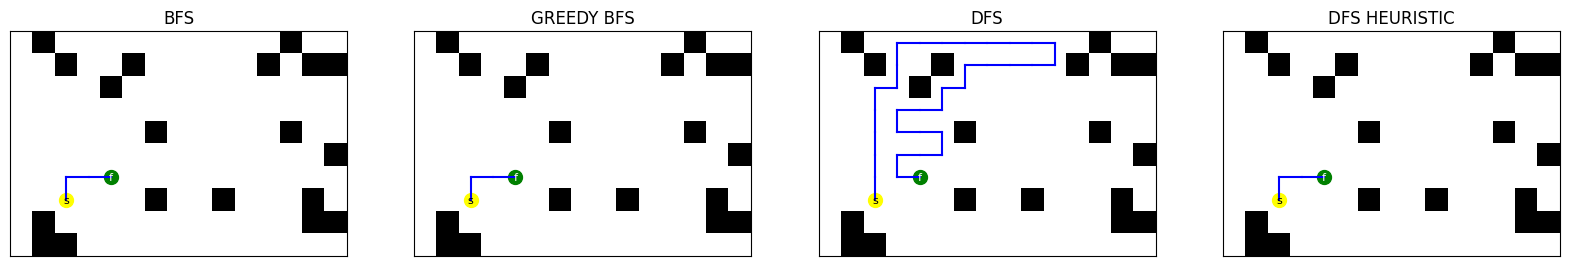

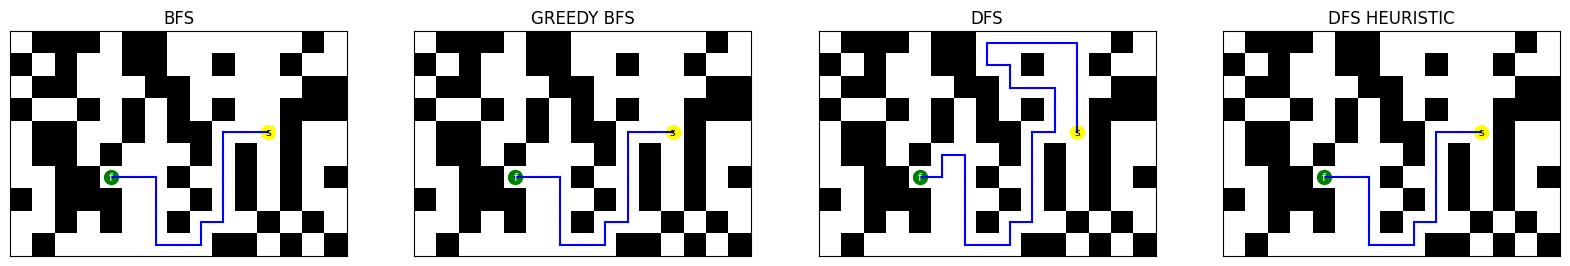

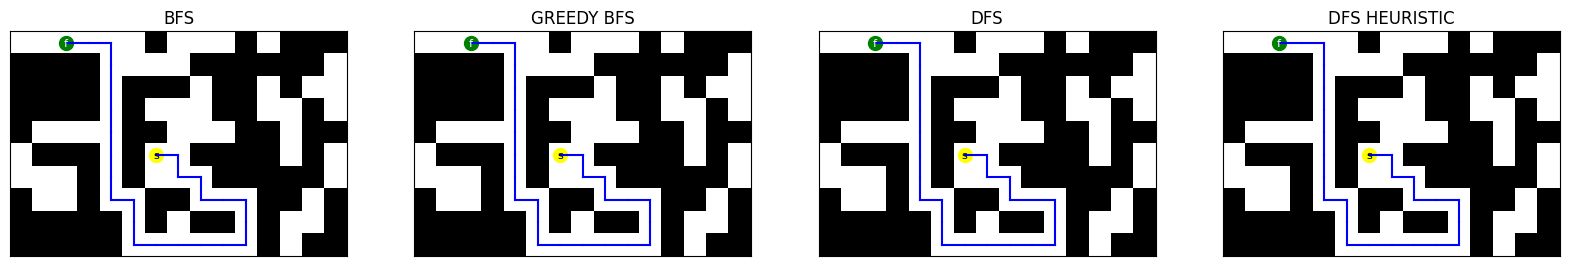

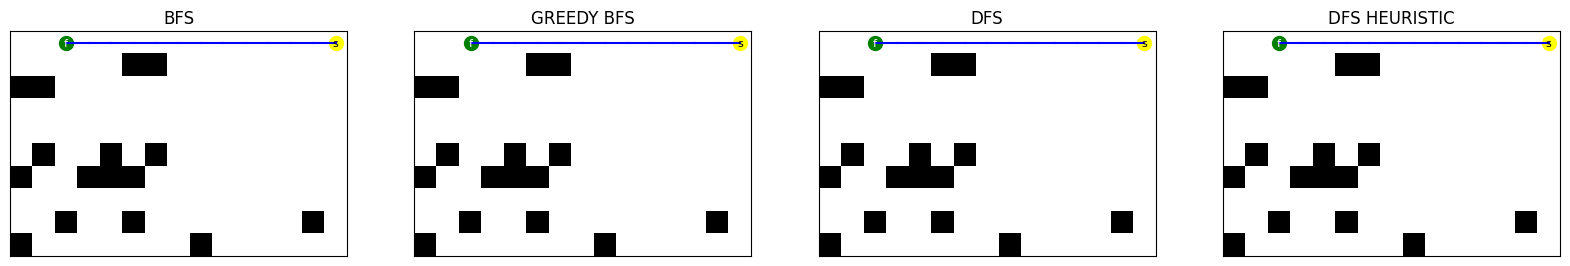

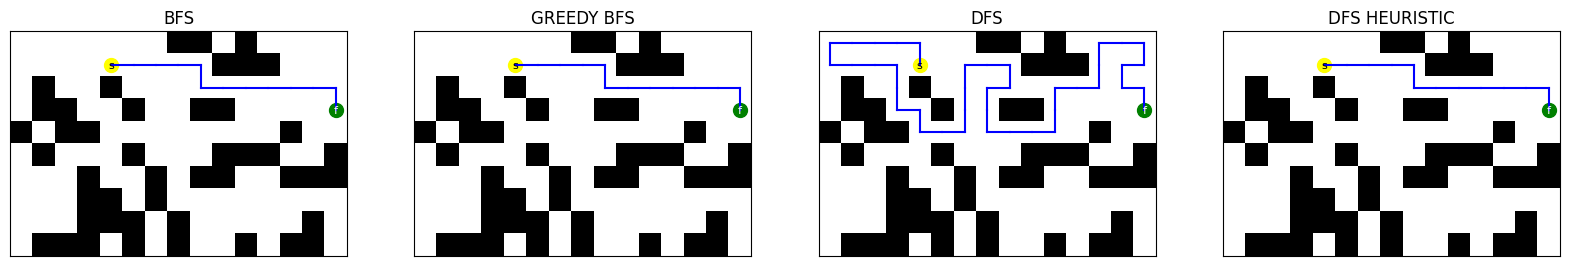

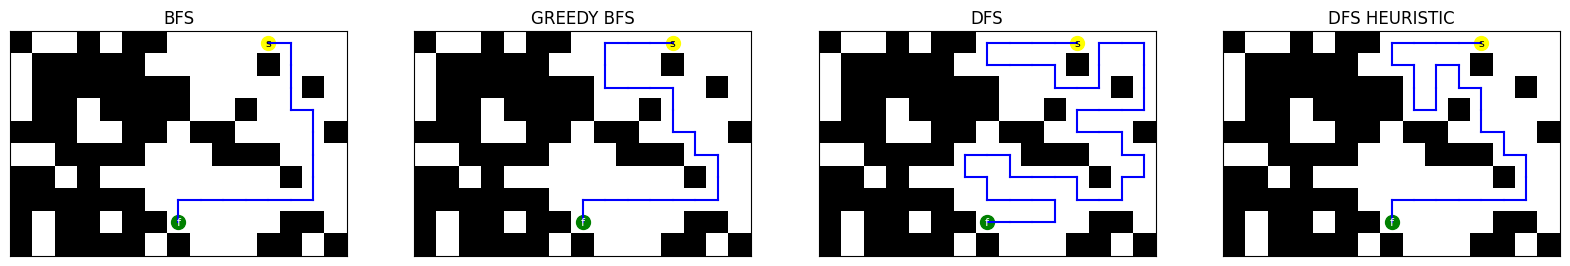

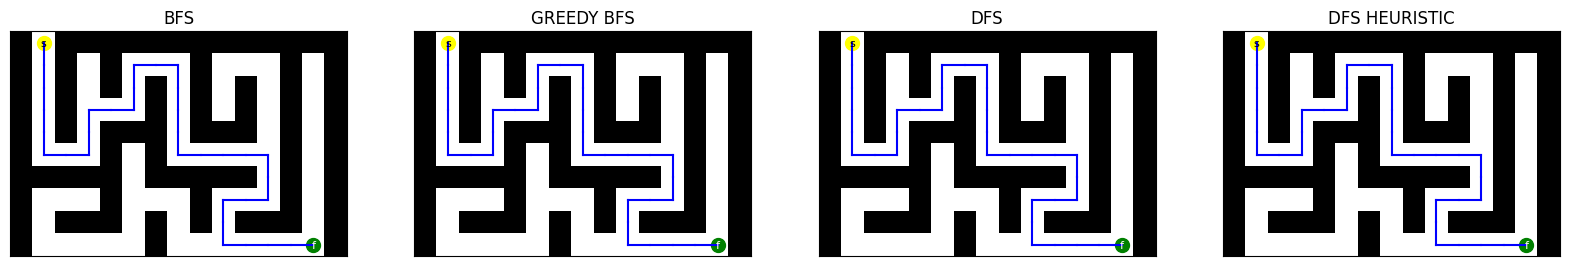

In [215]:
n = 1_000

datas = []
percent_blockages = [0.2, 0.4, 0.6]

graph = Graph(rows=10, cols=15)

to_search = [
    {
        "name": "bfs",
        "label": "BFS",
        "fct": bfs,
    },
    {
        "name": "greedy_bfs",
        "label": "GREEDY BFS",
        "fct": greedy_bfs,
    },
    {
        "name": "dfs",
        "label": "DFS",
        "fct": dfs,
    },
    {
        "name": "dfs_heur",
        "label": "DFS HEURISTIC",
        "fct": dfs_heuristic,
    }
]

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
    }

    graph.generate_grid(grid_type="fixed", variant=variant)

    _, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

    for i, search in enumerate(to_search):
        fct = search["fct"]
        name = search["name"]
        label = search["label"]
        path, complexity = graph.search(search["fct"])

        data[name] = {}

        data[name]["time"] = complexity["time"]
        data[name]["iterations"] = complexity["iterations"]
        data[name]["length"] = complexity["length"]

        plot_path(axes[i], path, c='blue',label=label)

    plt.show()

    datas.append(data)

for grid_type in ["random", "random-1"]:
    for percent in percent_blockages:
        data = {
            "percent": percent,
            "type": grid_type,
        }
        for i in range(n):
            graph.generate_grid(grid_type=grid_type, percent_blocked=percent)

            if i == n - 1:
                _, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
                plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

            for j, search in enumerate(to_search):
                fct = search["fct"]
                name = search["name"]
                label = search["label"]
                path, complexity = graph.search(search["fct"])

                if name not in data:
                    data[name] = {"time": 0, "iterations": 0, "length": 0}

                data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
                data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
                data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

                if i == n - 1:
                    plot_path(axes[j], path, c='blue',label=label)
        plt.show()
        datas.append(data)

# Maze grids
data = {
    "percent": 0,
    "type": "maze",
}
for i in range(n):
    graph.generate_grid(grid_type="maze")

    if i == n - 1:
        _, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
        plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

    for j, search in enumerate(to_search):
        fct = search["fct"]
        name = search["name"]
        label = search["label"]
        path, complexity = graph.search(search["fct"])

        if complexity["time"] is None: break

        if name not in data:
            data[name] = {"time": 0, "iterations": 0, "length": 0}

        data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
        data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
        data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

        if i == n - 1:
            plot_path(axes[j], path, c='blue',label=label)
plt.show()
datas.append(data)


In [216]:
data_df = {"percent": [], "type": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    for k in ["time", "iterations", "length"]:
        for value in to_search:
            t = value["name"]
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [217]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time                                iterations  \
                       bfs greedy_bfs       dfs  dfs_heur        bfs   
percent type                                                           
0.0     fixed_0   0.000304   0.000133  0.000079  0.000084  123.00000   
        fixed_1   0.000230   0.000157  0.000135  0.000102  111.00000   
        fixed_2   0.000217   0.000153  0.000061  0.000061  115.00000   
0.2     random    0.000106   0.000032  0.000084  0.000034   62.02100   
0.4     random    0.000076   0.000046  0.000065  0.000055   44.05300   
0.6     random    0.000044   0.000039  0.000033  0.000041   25.21100   
0.2     random-1  0.000168   0.000040  0.000087  0.000034  100.77100   
0.4     random-1  0.000132   0.000042  0.000080  0.000045   77.81300   
0.6     random-1  0.000096   0.000042  0.000057  0.000044   55.90300   
0.0     maze      0.000085   0.000074  0.000083  0.000071   49.17944   

                                                      length             \
                 greedy_bfs         dfs  dfs_heur        bfs greedy_bfs   
percent type                                                              
0.0     fixed_0   36.000000   40.000000  22.00000  19.000000  19.000000   
        fixed_1   45.000000  102.000000  38.00000  17.000000  17.000000   
        fixed_2   59.000000   40.000000  22.00000  19.000000  27.000000   
0.2     random    12.623000   77.942000  18.29400   9.568000  10.098000   
0.4     random    21.606000   58.658000  31.75200  13.876000  14.230000   
0.6     random    19.512000   29.180000  23.92600  14.462000  14.534000   
0.2     random-1  14.523000   79.911000  17.57900  12.281000  12.845000   
0.4     random-1  16.309000   71.103000  23.91300  12.669000  13.337000   
0.6     random-1  17.541000   49.497000  23.69300  13.443000  13.981000   
0.0     maze      39.879148   72.474352  42.48837  36.614091  36.614091   

                                         
                         dfs   dfs_heur  
percent type                             
0.0     fixed_0    39.000000  21.000000  
        fixed_1   101.000000  37.000000  
        fixed_2    39.000000  21.000000  
0.2     random     43.984000  12.604000  
0.4     random     21.344000  16.228000  
0.6     random     15.836000  15.320000  
0.2     random-1   55.553000  14.787000  
0.4     random-1   35.705000  16.045000  
0.6     random-1   26.999000  16.153000  
0.0     maze       36.614091  36.614091

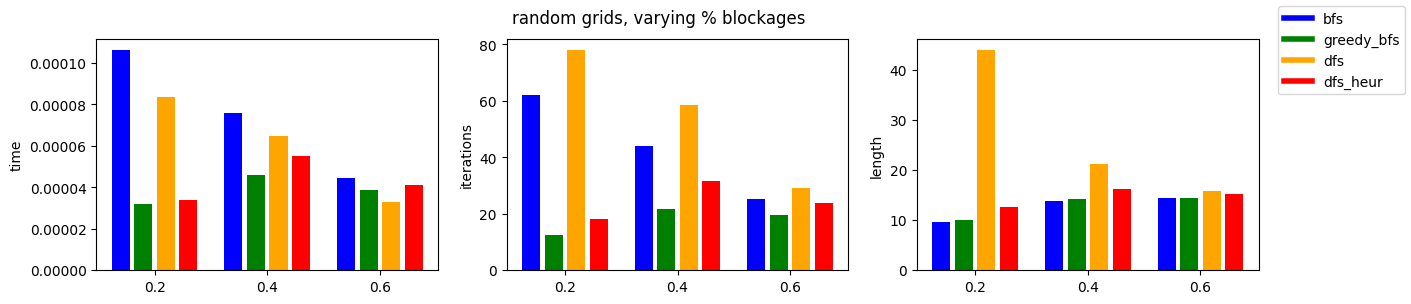

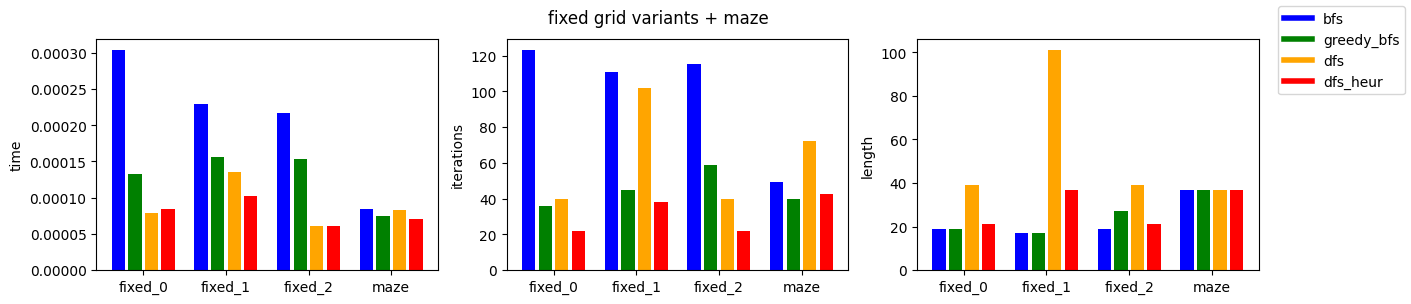

In [218]:
colors = {
    "bfs": "blue",
    "greedy_bfs": "green",
    "dfs": "orange",
    "dfs_heur": "red",
}

partition = df.xs("random", level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("random grids (method 1), varying % blockages")
plt.show()

partition = df.xs("random-1", level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("random grids (method 2), varying % blockages")
plt.show()

partition = df.xs(0, level=0)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("fixed grid variants + maze")
plt.show()

## Let's add another algorithm, but introduce costs.

A* algorithm is used here. The heuristic gave us some speed ups, but it isn't guaranteed to find the optimal path. We'll introduce costs here.

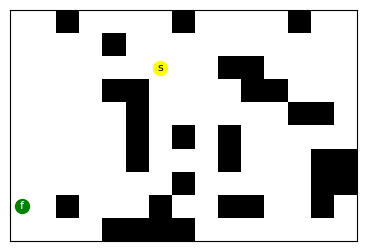

In [222]:
percent_blockage = 0.25

graph = Graph(rows=10, cols=15)
graph.generate_grid(grid_type="random-1", percent_blocked=percent_blockage)

plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.show()

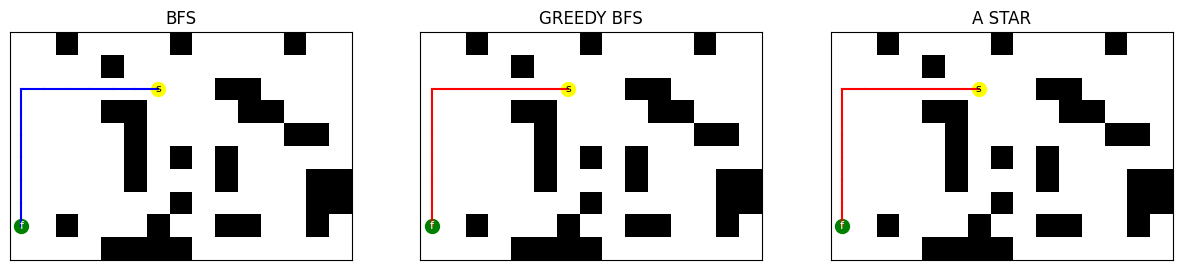

BFS:
Time: 0.00023984909057617188 (s)
# Iteractions: 110
Path length: 12

GREEDY BFS:
Time: 5.1975250244140625e-05 (s)
# Iteractions: 13
Path length: 12

A STAR:
Time: 0.00010395050048828125 (s)
# Iteractions: 35
Path length: 12


In [223]:
bfs_path, bfs_complexity = graph.search(bfs)
greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
astar_path, astar_complexity = graph.search(a_star)

_, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], greedy_bfs_path, c='red',label='GREEDY BFS')
plot_path(axes[2], astar_path, c='red',label='A STAR')

plt.show()

print("BFS:")
print("Time:", bfs_complexity["time"], "(s)")
print("# Iteractions:", bfs_complexity["iterations"])
print("Path length:", bfs_complexity["length"])

print()
print("GREEDY BFS:")
print("Time:", greedy_bfs_complexity["time"], "(s)")
print("# Iteractions:", greedy_bfs_complexity["iterations"])
print("Path length:", greedy_bfs_complexity["length"])

print()
print("A STAR:")
print("Time:", astar_complexity["time"], "(s)")
print("# Iteractions:", astar_complexity["iterations"])
print("Path length:", astar_complexity["length"])

### Let's see it in action

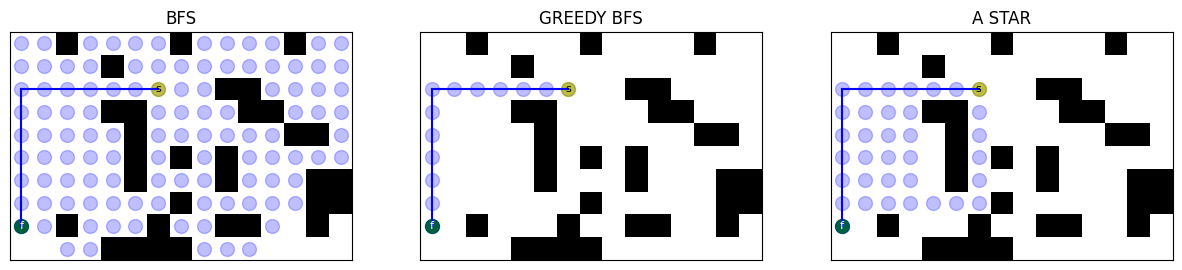

In [224]:
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("GREEDY BFS")
    axes[2].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

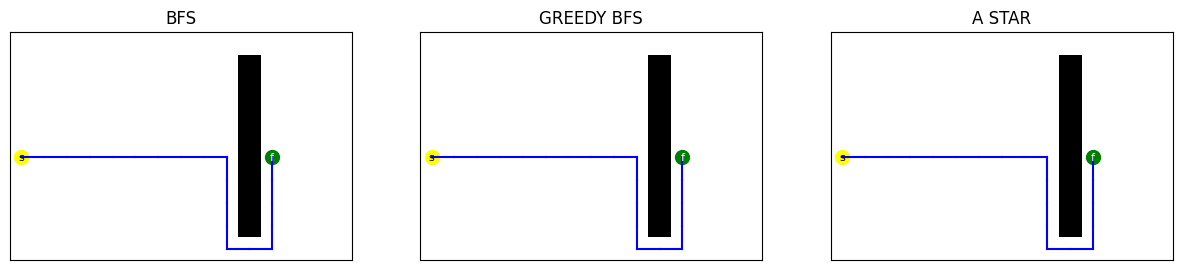

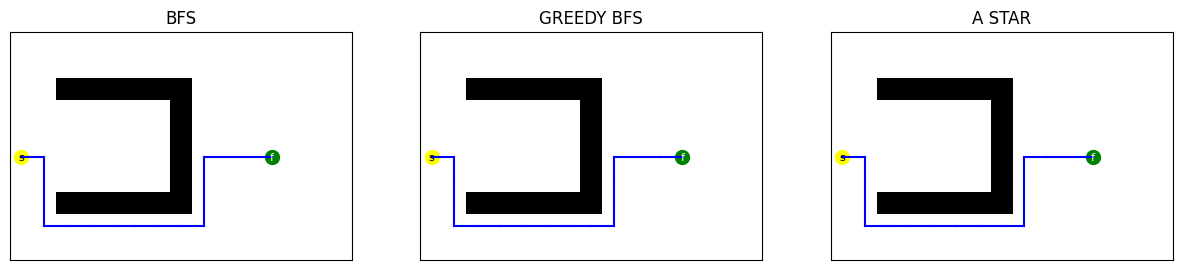

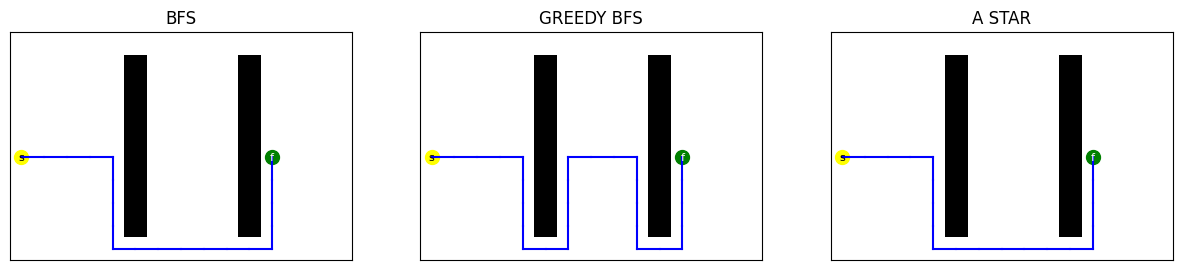

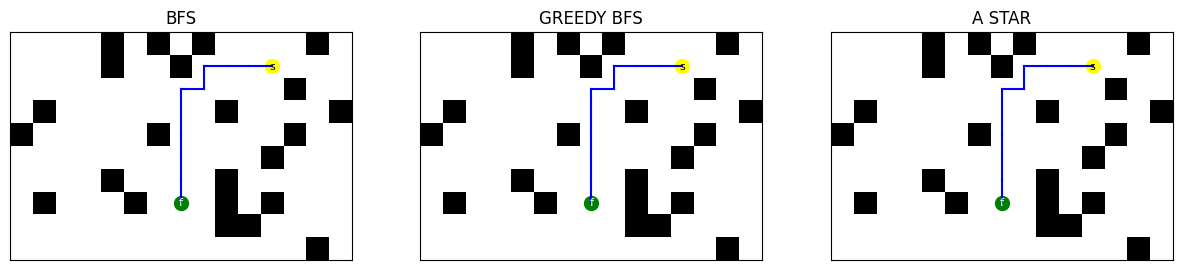

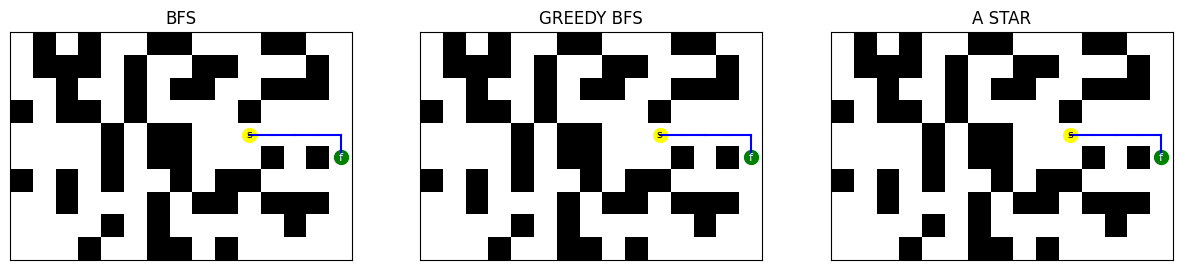

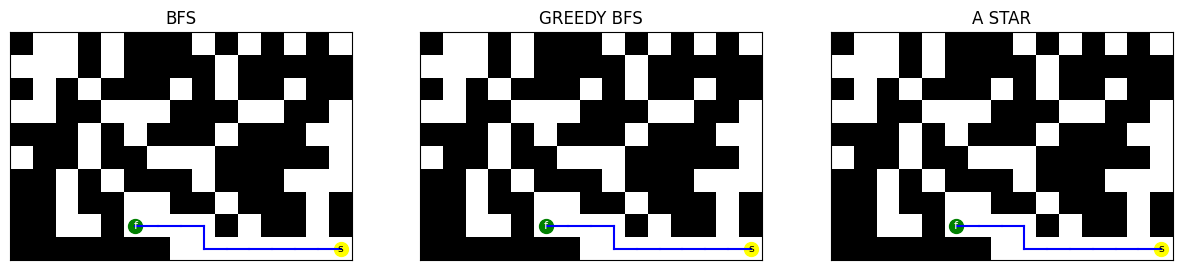

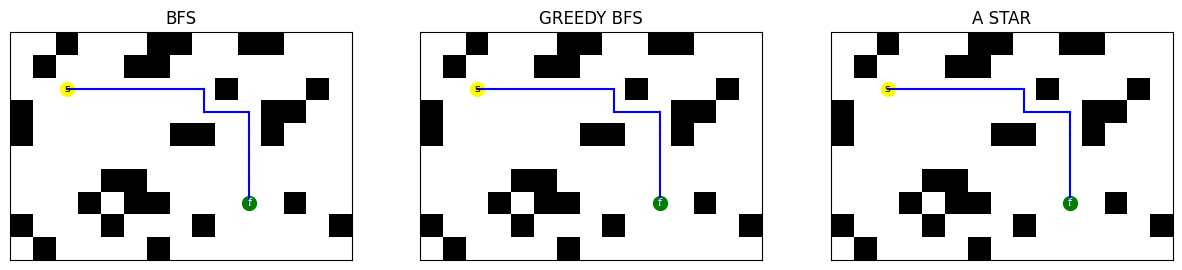

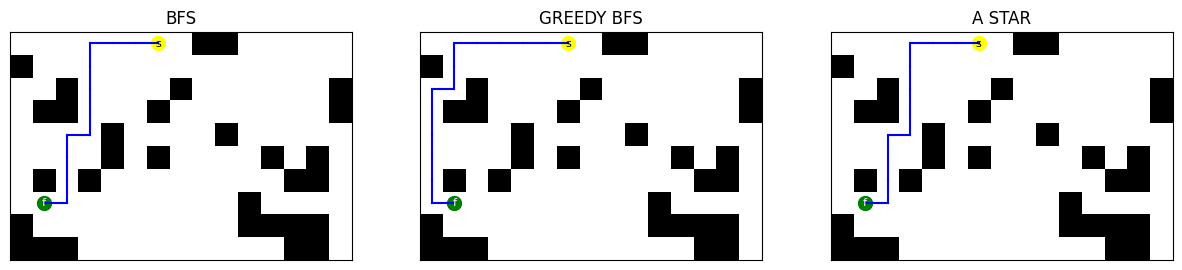

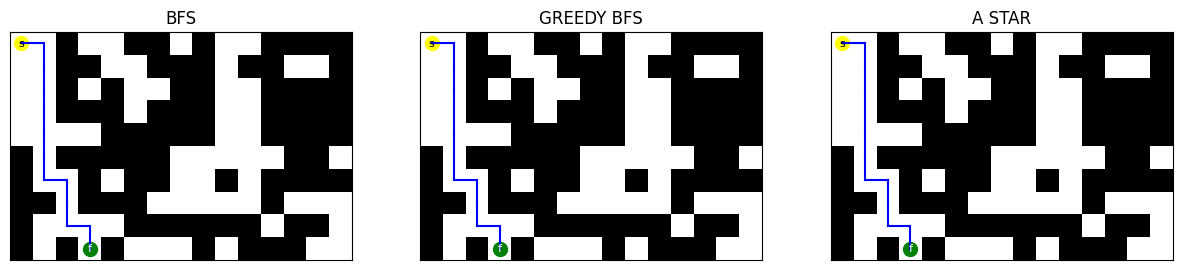

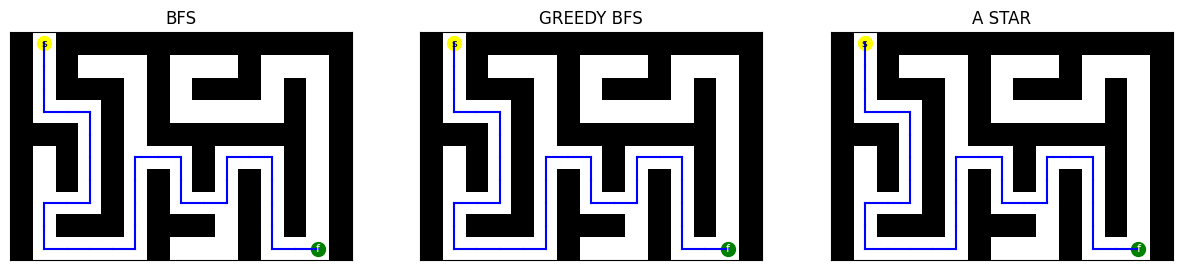

In [225]:
n = 1_000

datas = []
percent_blockages = [0.2, 0.4, 0.6]

graph = Graph(rows=10, cols=15)

to_search = [
    {
        "name": "bfs",
        "label": "BFS",
        "fct": bfs,
    },
    {
        "name": "greedy_bfs",
        "label": "GREEDY BFS",
        "fct": greedy_bfs,
    },
    {
        "name": "a_star",
        "label": "A STAR",
        "fct": a_star,
    },
]

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
    }

    graph.generate_grid(grid_type="fixed", variant=variant)

    _, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

    for i, search in enumerate(to_search):
        fct = search["fct"]
        name = search["name"]
        label = search["label"]
        path, complexity = graph.search(search["fct"])

        data[name] = {}

        data[name]["time"] = complexity["time"]
        data[name]["iterations"] = complexity["iterations"]
        data[name]["length"] = complexity["length"]

        plot_path(axes[i], path, c='blue',label=label)

    plt.show()

    datas.append(data)

for grid_type in ["random", "random-1"]:
    for percent in percent_blockages:
        data = {
            "percent": percent,
            "type": grid_type,
        }
        for i in range(n):
            graph.generate_grid(grid_type=grid_type, percent_blocked=percent)

            if i == n - 1:
                _, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
                plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

            for j, search in enumerate(to_search):
                fct = search["fct"]
                name = search["name"]
                label = search["label"]
                path, complexity = graph.search(search["fct"])

                if name not in data:
                    data[name] = {"time": 0, "iterations": 0, "length": 0}

                data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
                data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
                data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

                if i == n - 1:
                    plot_path(axes[j], path, c='blue',label=label)
        plt.show()
        datas.append(data)

# Maze grids
data = {
    "percent": 0,
    "type": "maze",
}
for i in range(n):
    graph.generate_grid(grid_type="maze")

    if i == n - 1:
        _, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
        plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

    for j, search in enumerate(to_search):
        fct = search["fct"]
        name = search["name"]
        label = search["label"]
        path, complexity = graph.search(search["fct"])

        if complexity["time"] is None: break

        if name not in data:
            data[name] = {"time": 0, "iterations": 0, "length": 0}

        data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
        data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
        data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

        if i == n - 1:
            plot_path(axes[j], path, c='blue',label=label)
plt.show()
datas.append(data)


In [226]:
data_df = {"percent": [], "type": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    for k in ["time", "iterations", "length"]:
        for value in to_search:
            t = value["name"]
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [227]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time                       iterations             \
                       bfs greedy_bfs    a_star         bfs greedy_bfs   
percent type                                                             
0.0     fixed_0   0.000214   0.000097  0.000196  123.000000  36.000000   
        fixed_1   0.000247   0.000118  0.000146  111.000000  45.000000   
        fixed_2   0.000217   0.000147  0.000172  115.000000  59.000000   
0.2     random    0.000110   0.000033  0.000045   62.957000  12.724000   
0.4     random    0.000073   0.000044  0.000050   41.994000  20.415000   
0.6     random    0.000046   0.000040  0.000042   25.695000  19.990000   
0.2     random-1  0.000168   0.000040  0.000062  101.486000  14.429000   
0.4     random-1  0.000129   0.000042  0.000059   76.668000  16.167000   
0.6     random-1  0.000096   0.000042  0.000055   56.415000  17.297000   
0.0     maze      0.000083   0.000074  0.000081   48.768373  39.533688   

                                length                        
                     a_star        bfs greedy_bfs     a_star  
percent type                                                  
0.0     fixed_0   96.000000  19.000000  19.000000  19.000000  
        fixed_1   47.000000  17.000000  17.000000  17.000000  
        fixed_2   72.000000  19.000000  27.000000  19.000000  
0.2     random    18.463000   9.650000  10.192000   9.650000  
0.4     random    23.829000  13.196000  13.518000  13.196000  
0.6     random    20.888000  14.906000  14.976000  14.906000  
0.2     random-1  24.980000  12.266000  12.840000  12.266000  
0.4     random-1  24.104000  12.623000  13.271000  12.623000  
0.6     random-1  23.303000  13.356000  13.968000  13.356000  
0.0     maze      42.592582  36.372572  36.372572  36.372572

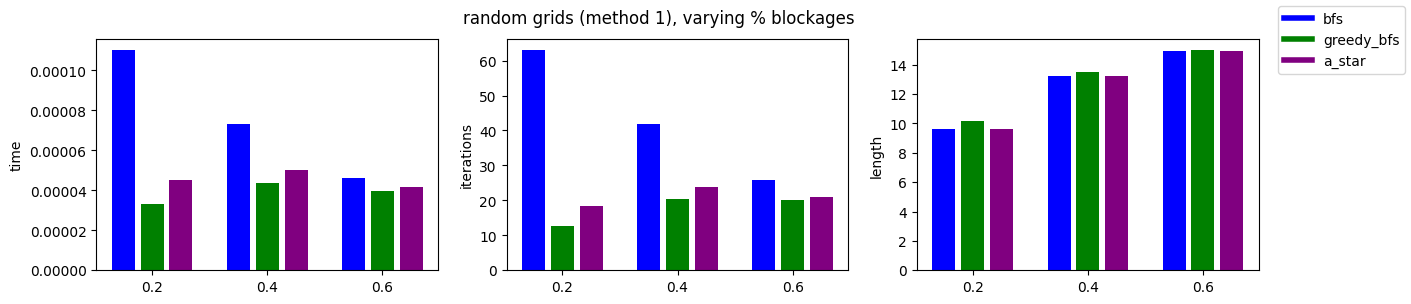

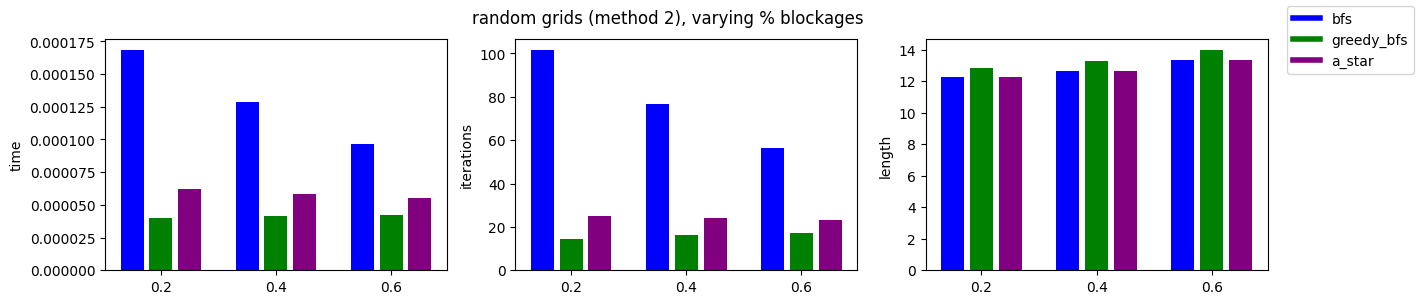

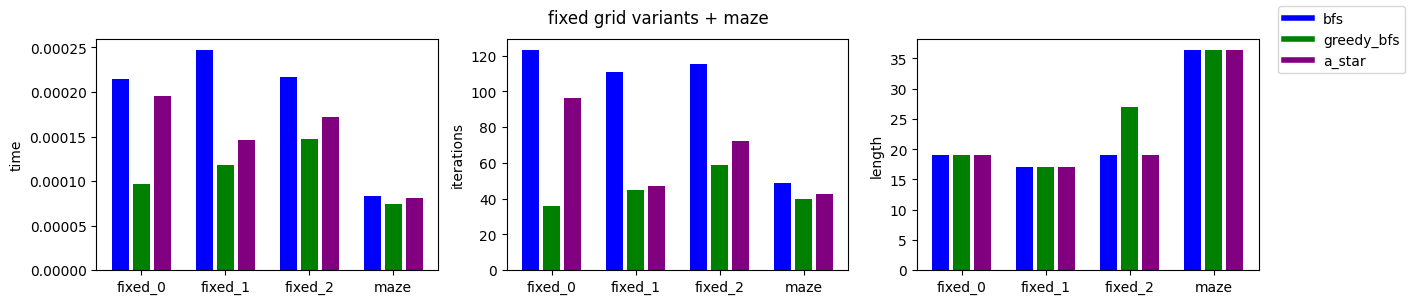

In [229]:
colors = {
    "bfs": "blue",
    "greedy_bfs": "green",
    "a_star": "purple"
}

partition = df.xs("random", level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("random grids (method 1), varying % blockages")
plt.show()

partition = df.xs("random-1", level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("random grids (method 2), varying % blockages")
plt.show()

partition = df.xs(0, level=0)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("fixed grid variants + maze")
plt.show()

# Exhaustive Search

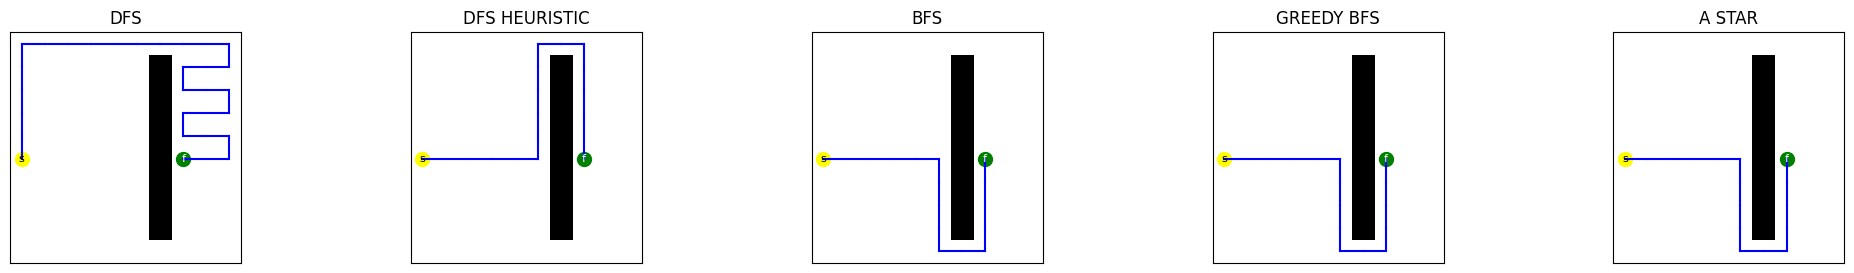

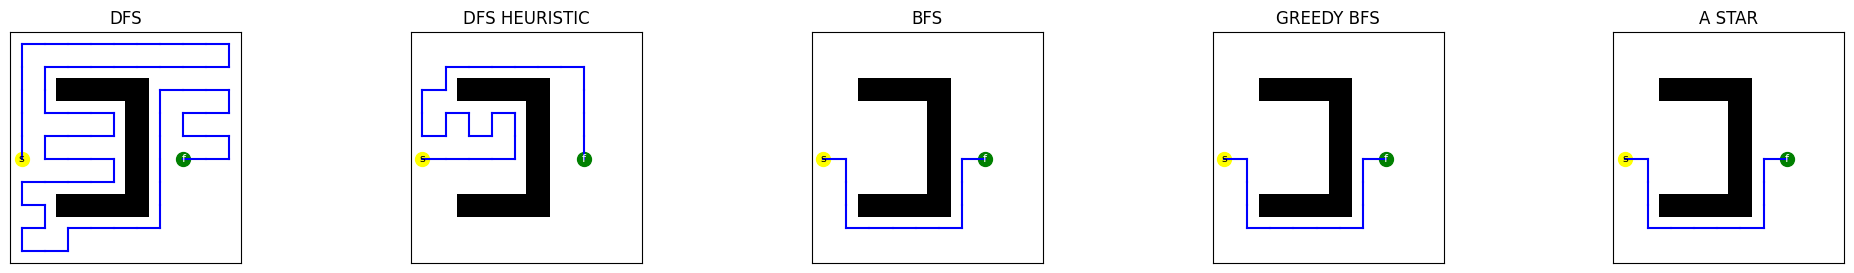

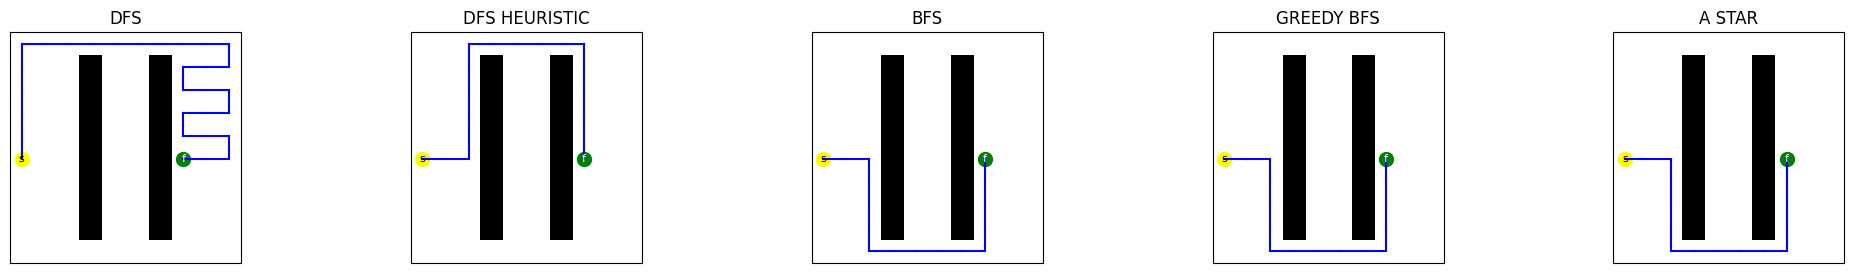

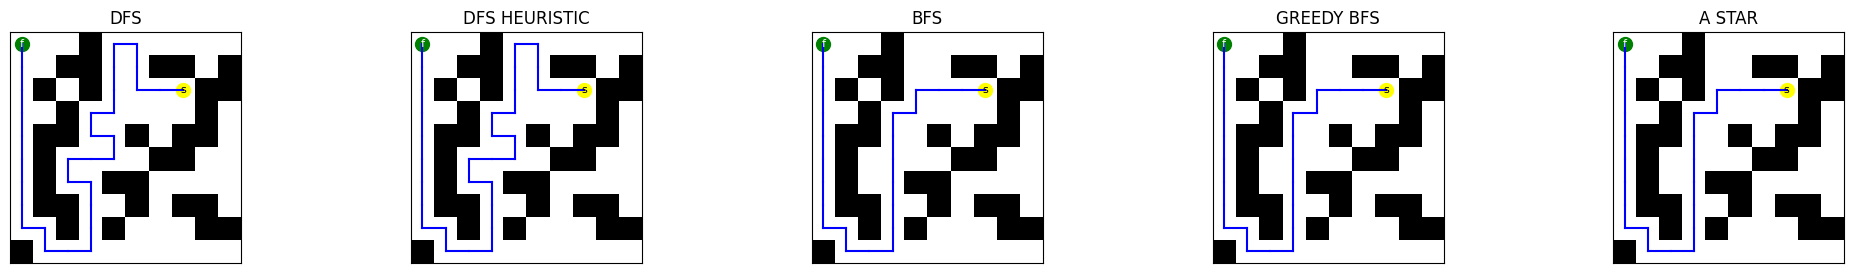

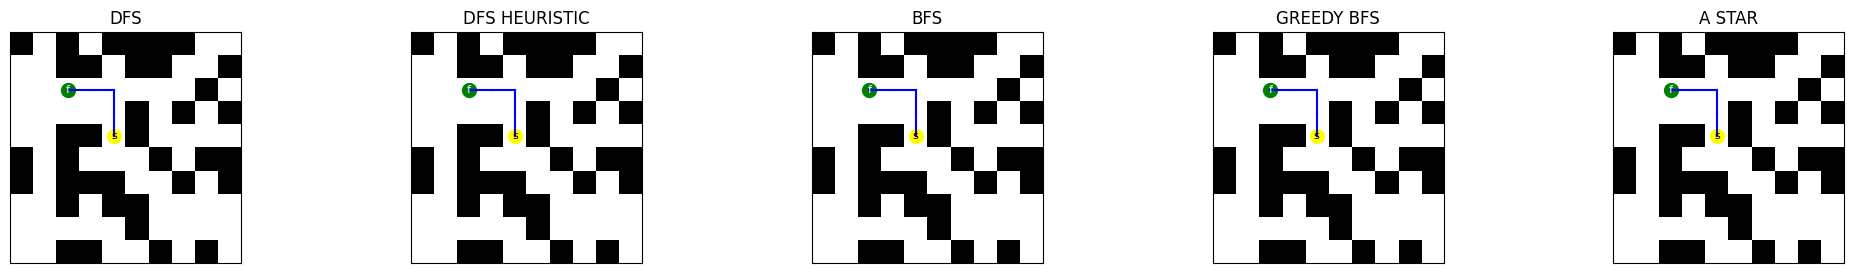

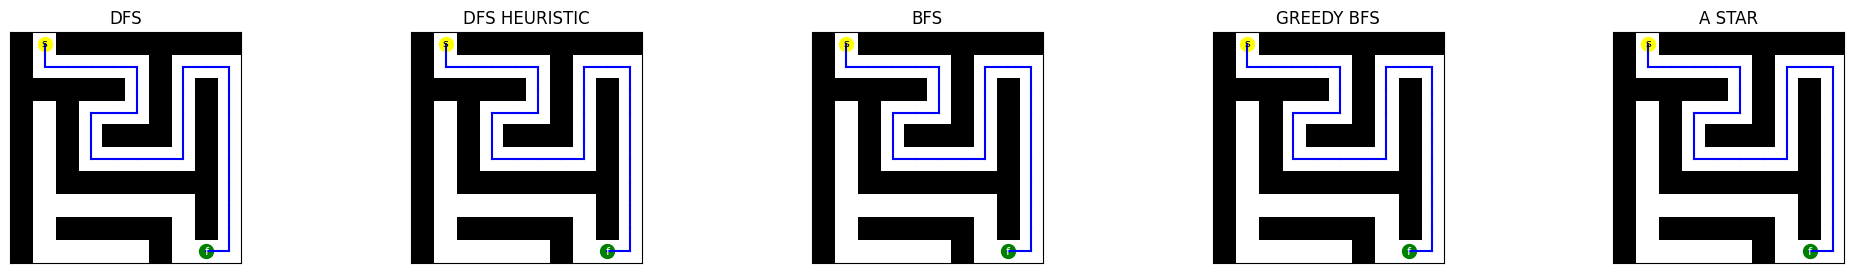

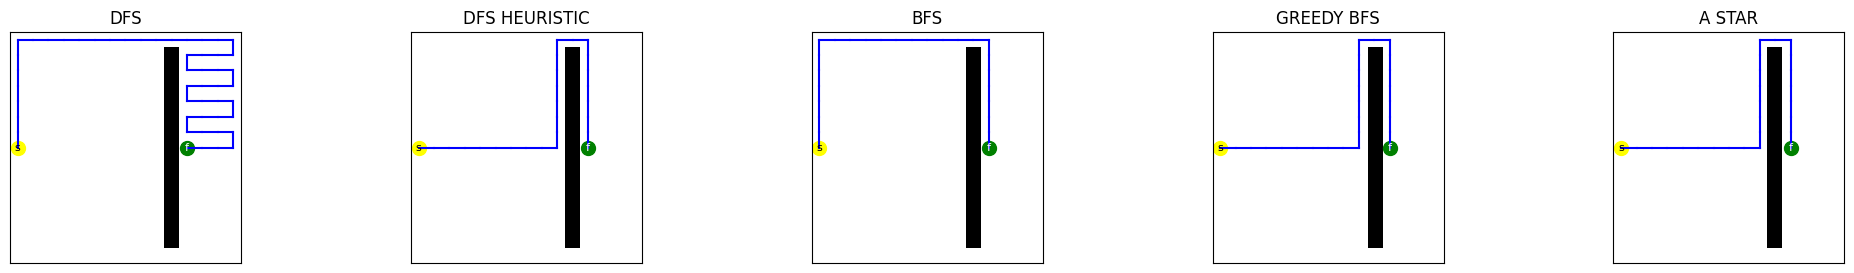

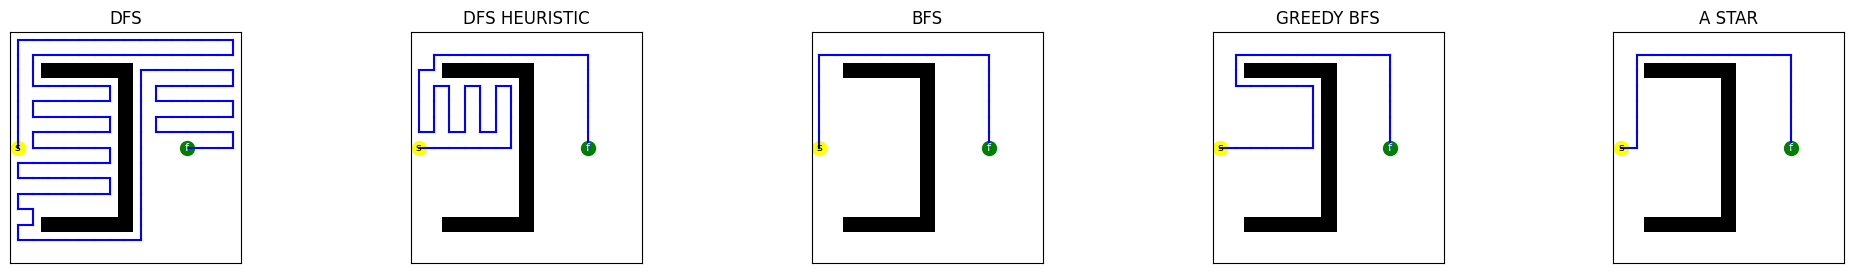

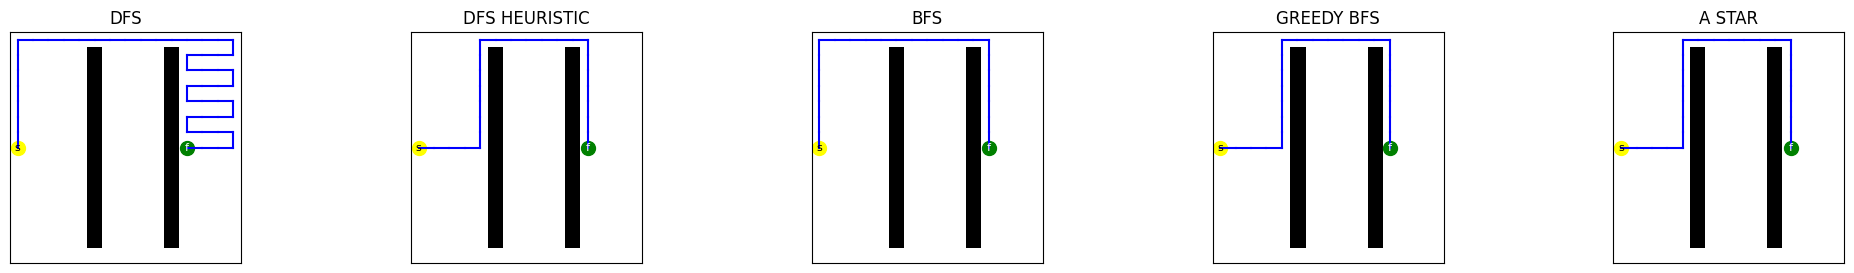

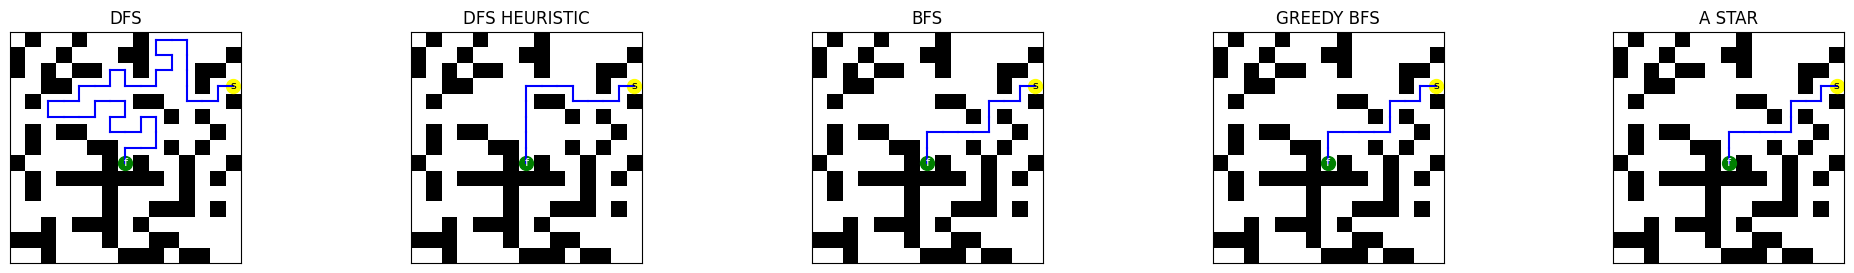

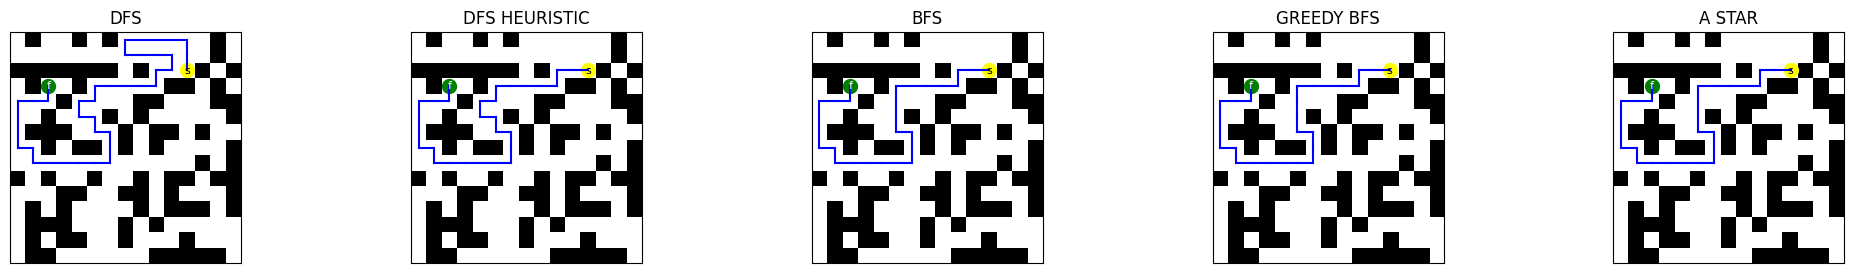

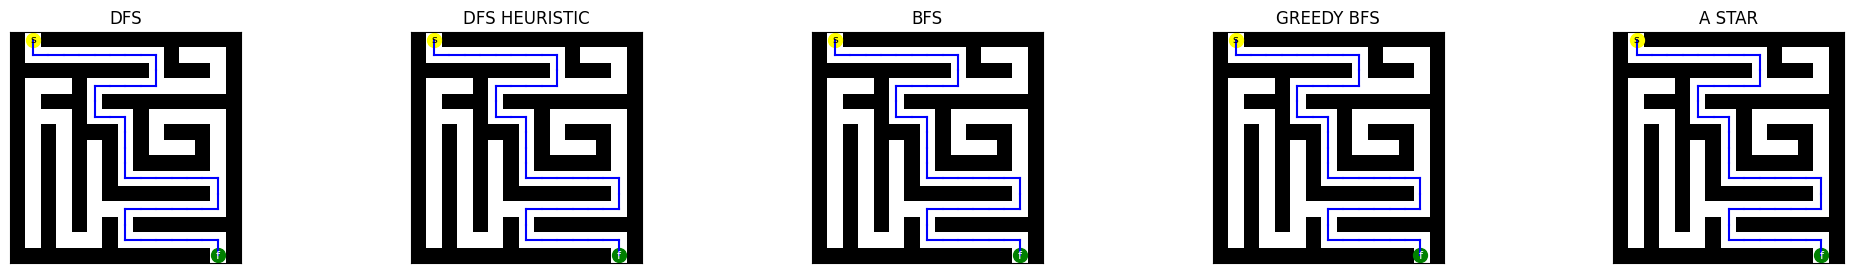

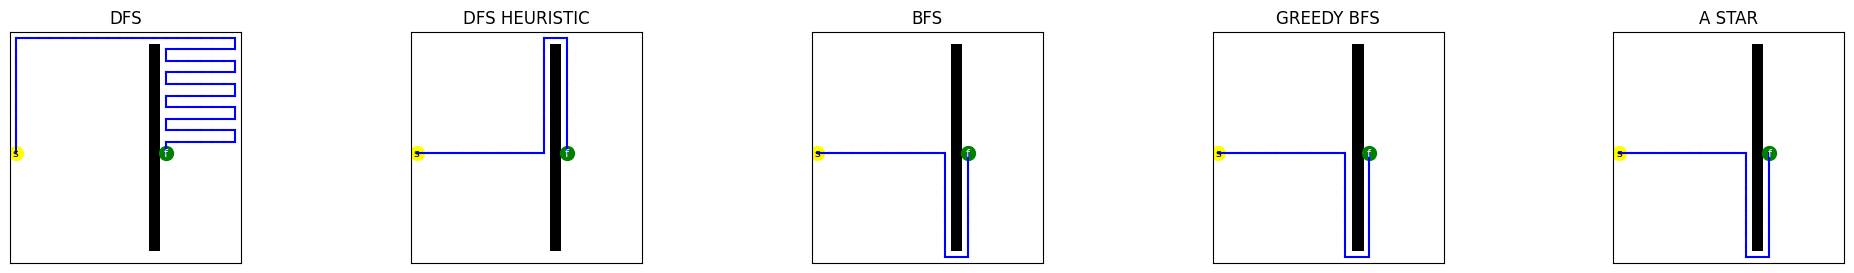

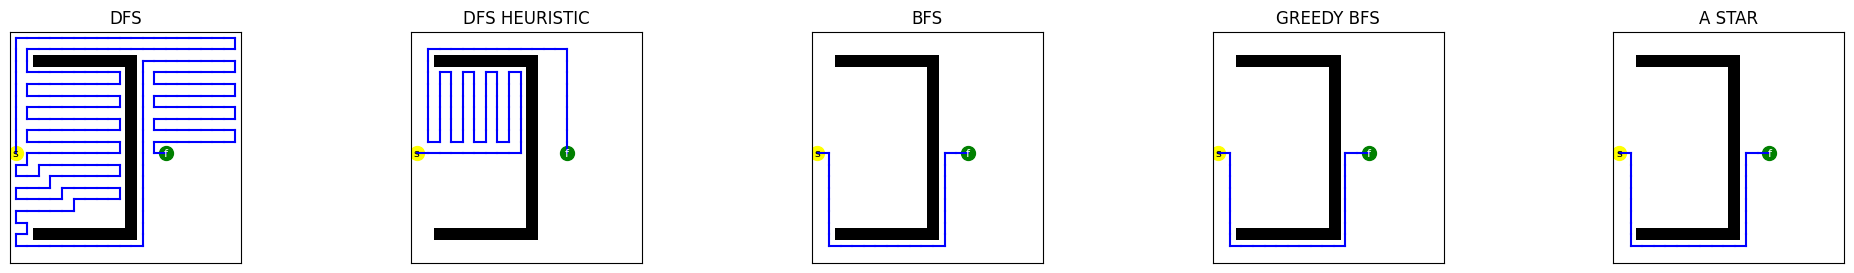

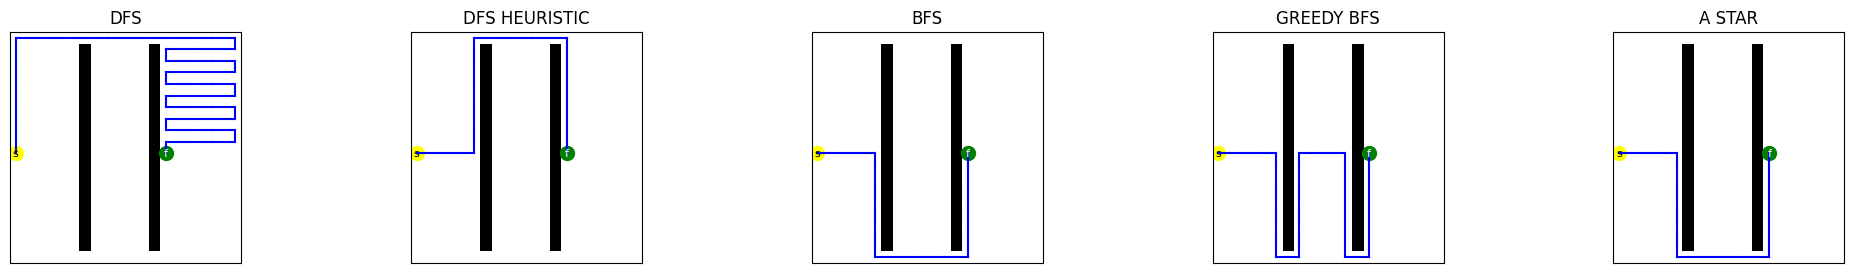

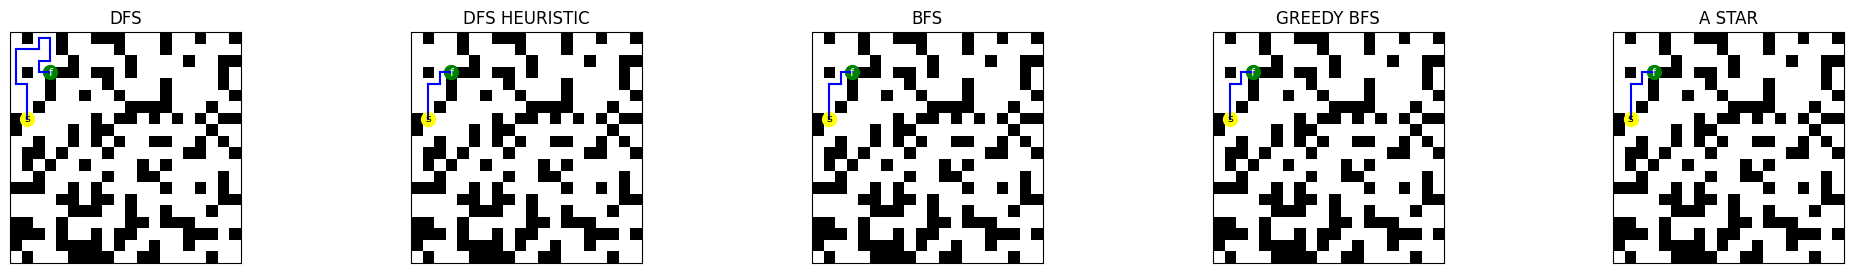

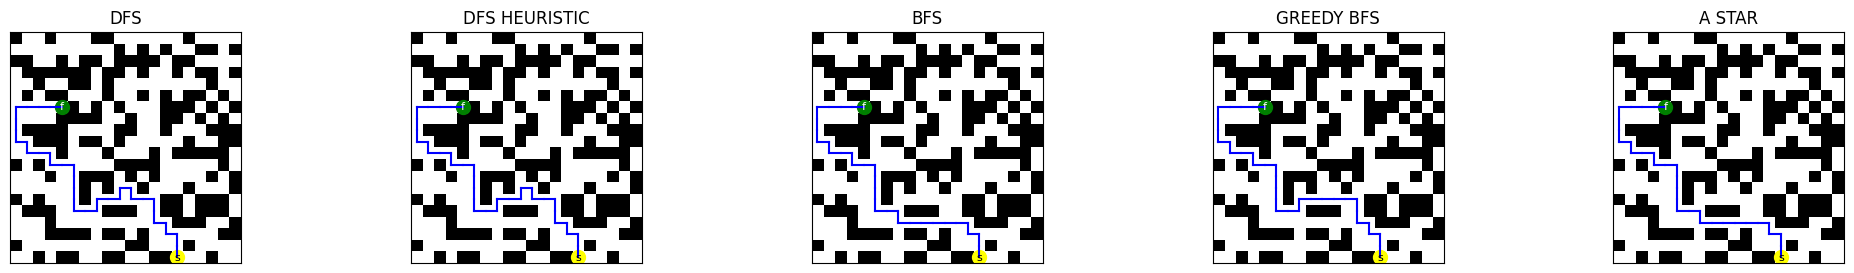

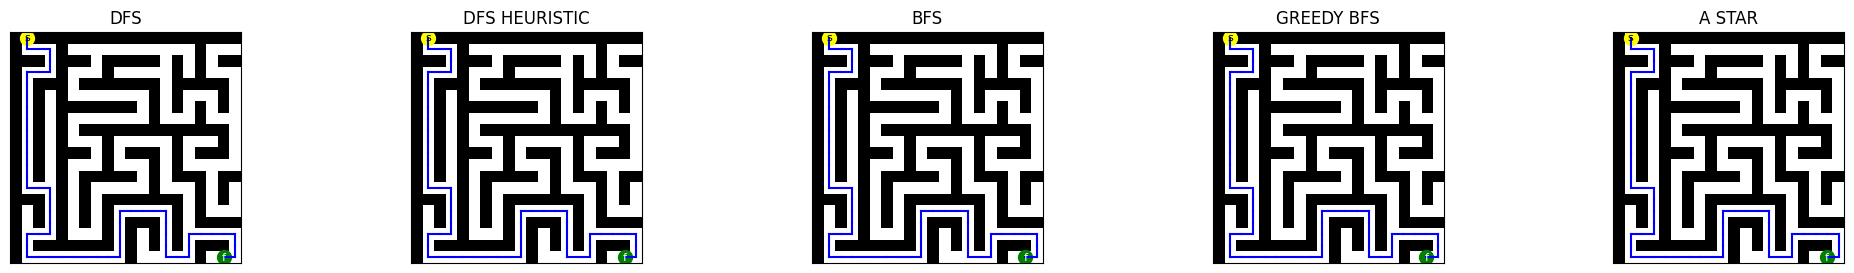

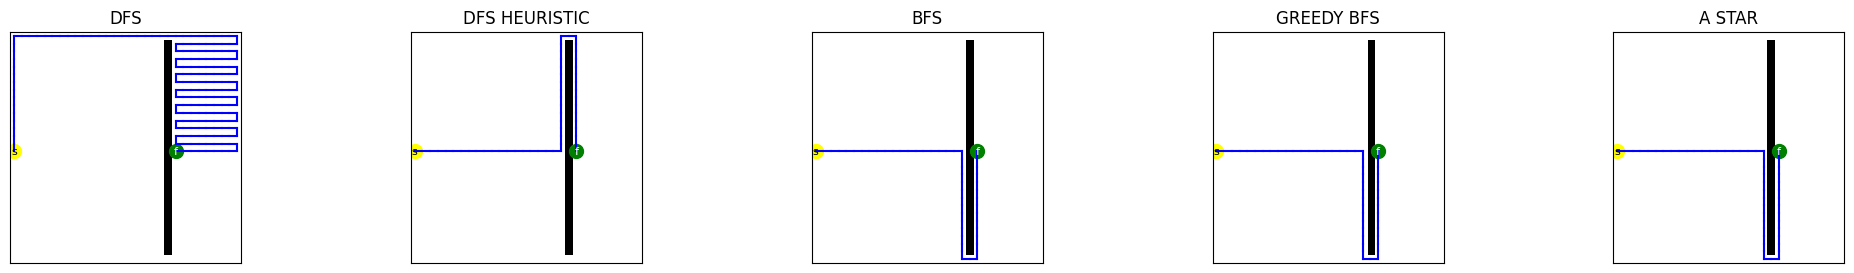

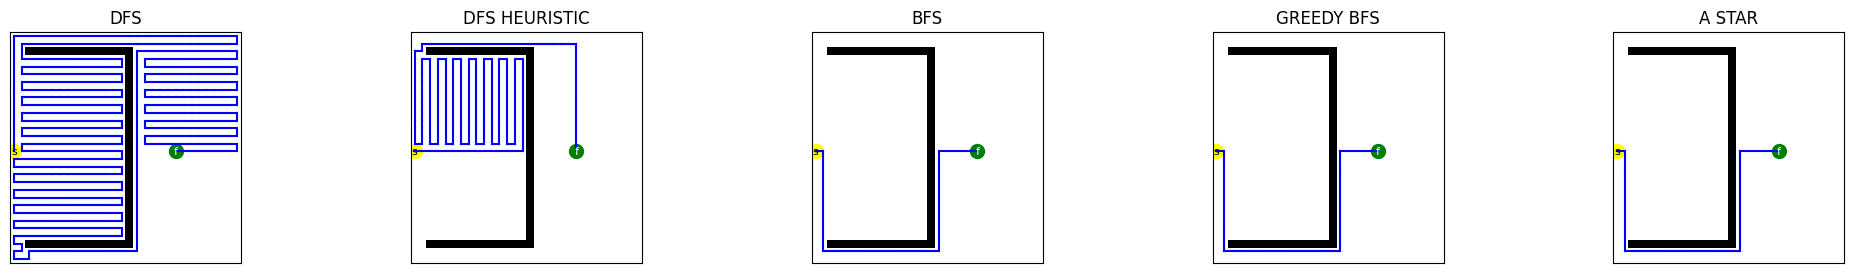

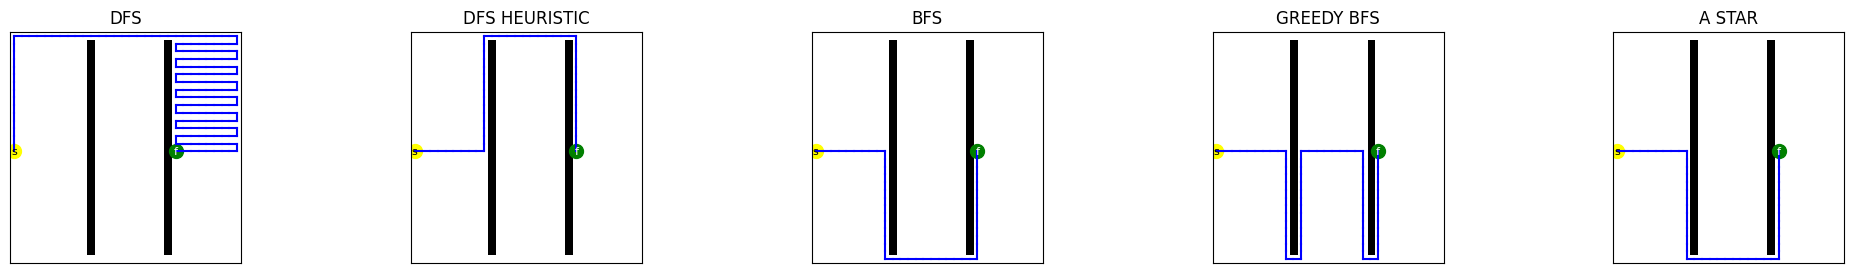

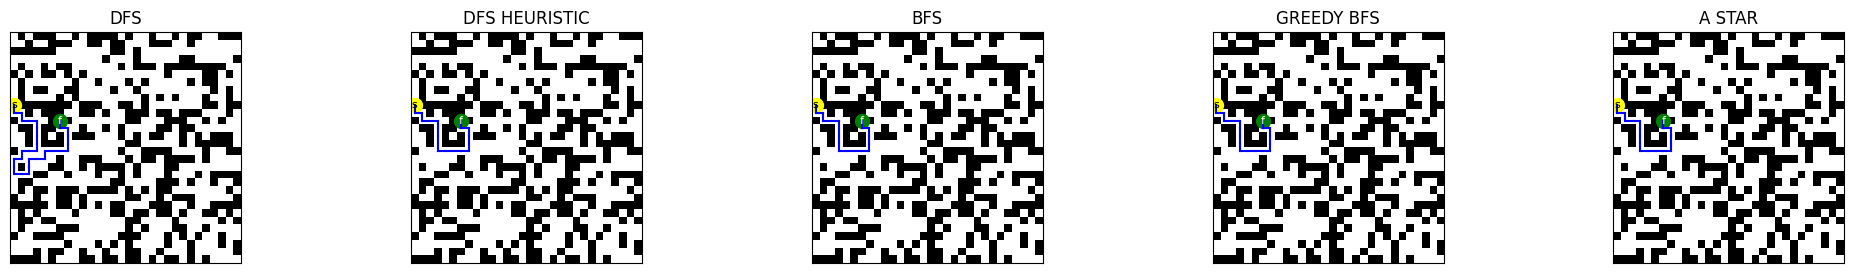

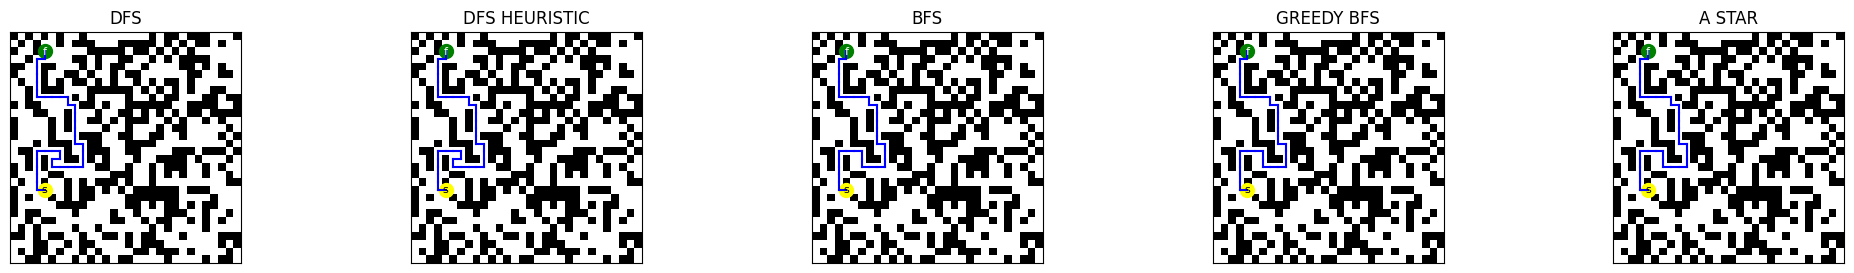

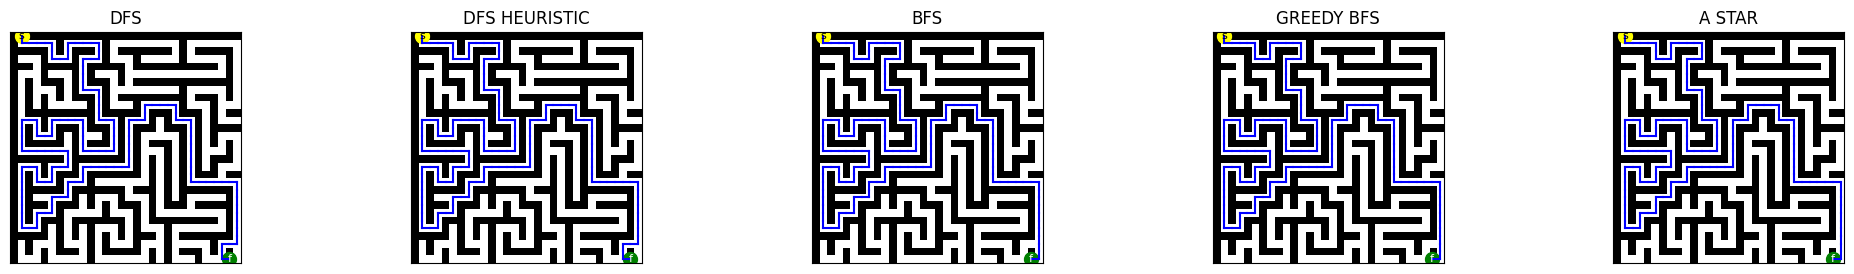

In [231]:
n = 250

datas = []

dimensions = [(10,10), (15,15), (20,20), (30,30)]
percent_blockages = [0.2, 0.4, 0.6]

to_search = [
    {
        "name": "dfs",
        "label": "DFS",
        "fct": dfs,
    },
    {
        "name": "dfs_heur",
        "label": "DFS HEURISTIC",
        "fct": dfs_heuristic,
    },
    {
        "name": "bfs",
        "label": "BFS",
        "fct": bfs,
    },
    {
        "name": "greedy_bfs",
        "label": "GREEDY BFS",
        "fct": greedy_bfs,
    },
    {
        "name": "a_star",
        "label": "A STAR",
        "fct": a_star,
    }
]

for (rows, cols) in dimensions:
    
    graph = Graph(rows=rows, cols=cols)

    for variant in [0,1,2]:
        data = {
            "percent": 0,
            "dimension": (rows, cols),
            "type": "fixed_" + str(variant),
        }
        graph.generate_grid(grid_type="fixed", variant=variant)

        _, axes = plt.subplots(ncols=len(to_search), nrows=1, figsize=(len(to_search) * 5, 3))
        plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

        for i, search in enumerate(to_search):
            fct = search["fct"]
            name = search["name"]
            label = search["label"]
            path, complexity = graph.search(search["fct"])

            data[name] = {}

            data[name]["time"] = complexity["time"]
            data[name]["iterations"] = complexity["iterations"]
            data[name]["length"] = complexity["length"]

            plot_path(axes[i], path, c='blue',label=label)

        plt.show()

        datas.append(data)

    # Random grids with varying percent blockages
    for grid_type in ["random", "random-1"]:
        for percent in percent_blockages:
            data = {
                "percent": percent,
                "dimension": (rows, cols),
                "type": grid_type,
            }
            for i in range(n):
                graph.generate_grid(grid_type="random", percent_blocked=percent)

                if i == n - 1 and percent == 0.4:
                    _, axes = plt.subplots(ncols=len(to_search), nrows=1, figsize=(len(to_search) * 5, 3))
                    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

                for j, search in enumerate(to_search):
                    fct = search["fct"]
                    name = search["name"]
                    label = search["label"]
                    path, complexity = graph.search(search["fct"])

                    if name not in data:
                        data[name] = {"time": 0, "iterations": 0, "length": 0}

                    data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
                    data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
                    data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

                    if i == n - 1 and percent == 0.4:
                        plot_path(axes[j], path, c='blue',label=label)

            if percent == 0.4:
                plt.show()
            datas.append(data)
    # Maze grids
    data = {
        "percent": 0,
        "dimension": (rows, cols),
        "type": "maze",
    }
    for i in range(n):
        graph.generate_grid(grid_type="maze")

        if i == n - 1:
            _, axes = plt.subplots(ncols=len(to_search), nrows=1, figsize=(len(to_search) * 5, 3))
            plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

        for j, search in enumerate(to_search):
            fct = search["fct"]
            name = search["name"]
            label = search["label"]
            path, complexity = graph.search(search["fct"])

            if complexity["time"] is None: break

            if name not in data:
                data[name] = {"time": 0, "iterations": 0, "length": 0}

            data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
            data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
            data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

            if i == n - 1:
                plot_path(axes[j], path, c='blue',label=label)
    
    plt.show()
    datas.append(data)




In [234]:
data_df = {"percent": [], "type": [], "dimension": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    data_df["dimension"].append(d["dimension"])
    for k in ["time", "iterations", "length"]:
        for value in to_search:
            t = value["name"]
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [235]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type', 'dimension'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time                                           \
                                 dfs  dfs_heur       bfs greedy_bfs    a_star   
percent type     dimension                                                      
0.0     fixed_0  (10, 10)   0.000050  0.000050  0.000143   0.000078  0.000124   
        fixed_1  (10, 10)   0.000097  0.000073  0.000155   0.000086  0.000091   
        fixed_2  (10, 10)   0.000052  0.000050  0.000138   0.000108  0.000102   
0.2     random   (10, 10)   0.000054  0.000025  0.000075   0.000027  0.000035   
0.4     random   (10, 10)   0.000044  0.000040  0.000057   0.000036  0.000042   
0.6     random   (10, 10)   0.000025  0.000029  0.000035   0.000029  0.000031   
0.2     random-1 (10, 10)   0.000056  0.000026  0.000077   0.000027  0.000034   
0.4     random-1 (10, 10)   0.000044  0.000038  0.000057   0.000035  0.000039   
0.6     random-1 (10, 10)   0.000025  0.000032  0.000036   0.000032  0.000033   
0.0     maze     (10, 10)   0.000055  0.000051  0.000056   0.000051  0.000054   
        fixed_0  (15, 15)   0.000073  0.000069  0.000389   0.000155  0.000324   
        fixed_1  (15, 15)   0.000197  0.000125  0.000375   0.000224  0.000578   
        fixed_2  (15, 15)   0.000075  0.000068  0.000379   0.000147  0.000252   
0.2     random   (15, 15)   0.000122  0.000042  0.000169   0.000039  0.000060   
0.4     random   (15, 15)   0.000095  0.000085  0.000109   0.000062  0.000073   
0.6     random   (15, 15)   0.000043  0.000055  0.000061   0.000052  0.000055   
0.2     random-1 (15, 15)   0.000117  0.000045  0.000164   0.000041  0.000059   
0.4     random-1 (15, 15)   0.000095  0.000078  0.000109   0.000062  0.000078   
0.6     random-1 (15, 15)   0.000040  0.000051  0.000057   0.000050  0.000053   
0.0     maze     (15, 15)   0.000150  0.000089  0.000109   0.000093  0.000102   
        fixed_0  (20, 20)   0.000119  0.000084  0.000604   0.000257  0.000516   
        fixed_1  (20, 20)   0.000369  0.000211  0.000551   0.000349  0.000364   
        fixed_2  (20, 20)   0.000151  0.000080  0.000574   0.000374  0.000440   
0.2     random   (20, 20)   0.000204  0.000063  0.000265   0.000049  0.000080   
0.4     random   (20, 20)   0.000161  0.000150  0.000172   0.000094  0.000121   
0.6     random   (20, 20)   0.000058  0.000078  0.000084   0.000073  0.000078   
0.2     random-1 (20, 20)   0.000221  0.000048  0.000272   0.000050  0.000082   
0.4     random-1 (20, 20)   0.000152  0.000126  0.000169   0.000087  0.000112   
0.6     random-1 (20, 20)   0.000063  0.000085  0.000091   0.000079  0.000083   
0.0     maze     (20, 20)   0.000251  0.000181  0.000199   0.000171  0.000196   
        fixed_0  (30, 30)   0.000215  0.000126  0.001377   0.000533  0.001298   
        fixed_1  (30, 30)   0.000752  0.000501  0.001483   0.000824  0.001265   
        fixed_2  (30, 30)   0.000214  0.000118  0.001353   0.000878  0.001091   
0.2     random   (30, 30)   0.000465  0.000102  0.000588   0.000073  0.000151   
0.4     random   (30, 30)   0.000338  0.000285  0.000361   0.000166  0.000244   
0.6     random   (30, 30)   0.000091  0.000128  0.000129   0.000116  0.000124   
0.2     random-1 (30, 30)   0.000446  0.000097  0.000519   0.000064  0.000124   
0.4     random-1 (30, 30)   0.000335  0.000284  0.000323   0.000159  0.000229   
0.6     random-1 (30, 30)   0.000090  0.000123  0.000127   0.000114  0.000123   
0.0     maze     (30, 30)   0.000604  0.000393  0.000442   0.000364  0.000452   

                            iterations                                      \
                                   dfs    dfs_heur         bfs  greedy_bfs   
percent type     dimension                                                   
0.0     fixed_0  (10, 10)    30.000000   18.000000   81.000000   32.000000   
        fixed_1  (10, 10)    72.000000   28.000000   75.000000   33.000000   
        fixed_2  (10, 10)    30.000000   18.000000   73.000000   45.000000   
0.2     random   (10, 10)    49.212000   12.724000   41.256000   10.316000   
0.

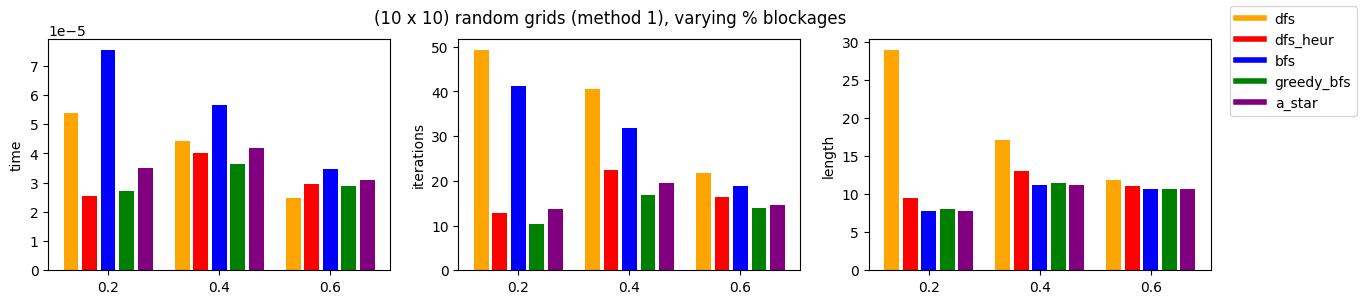

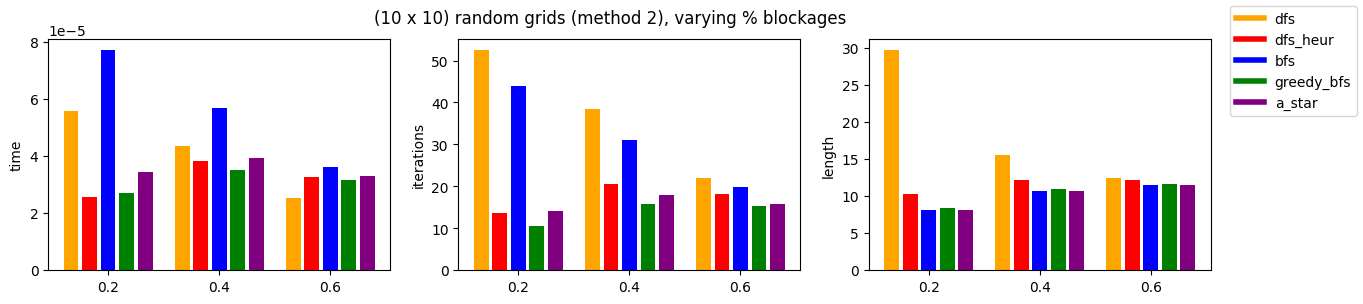

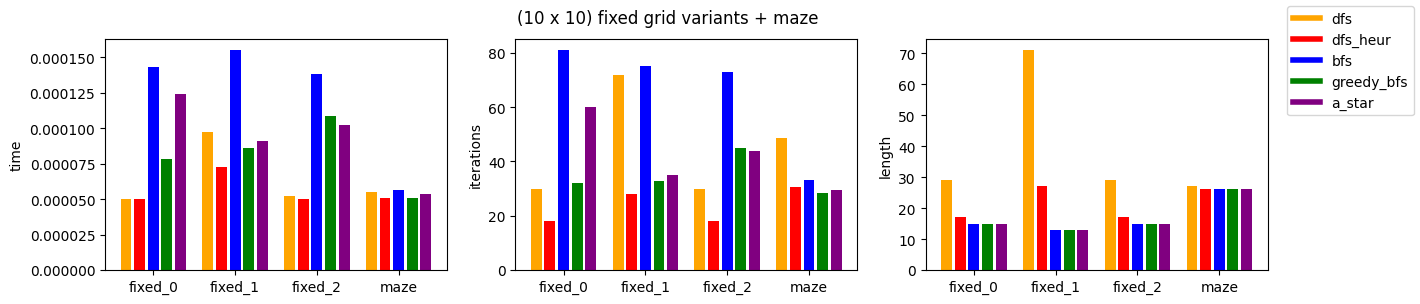

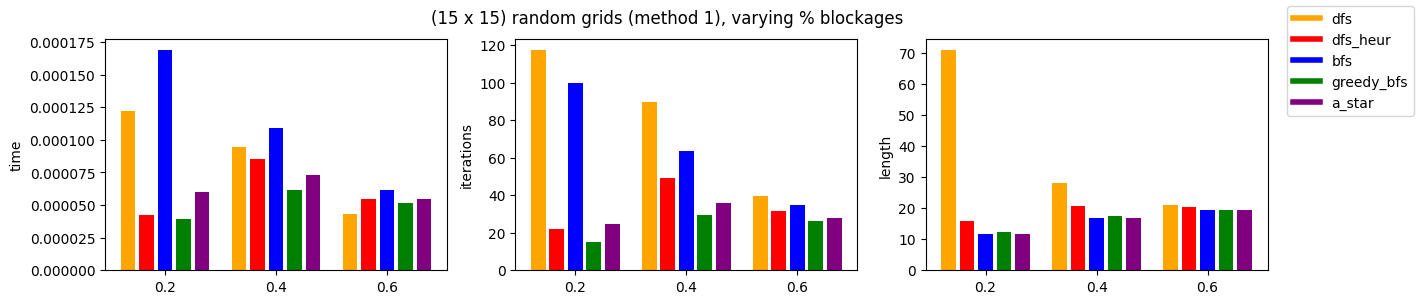

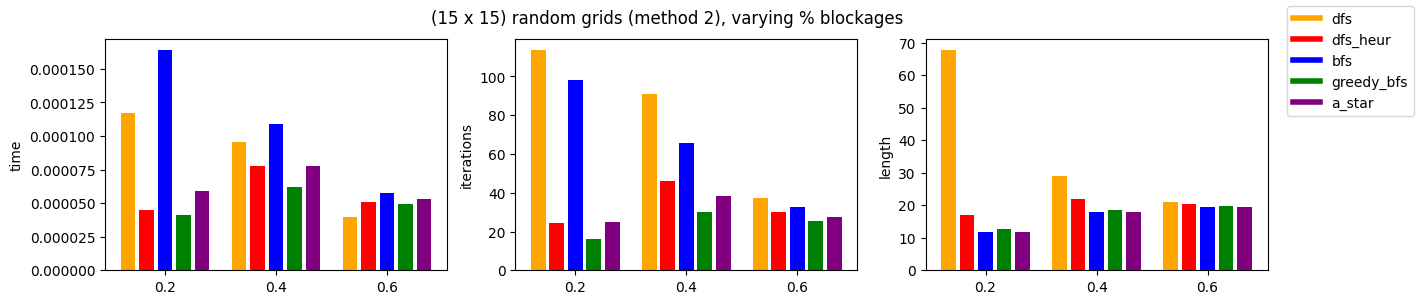

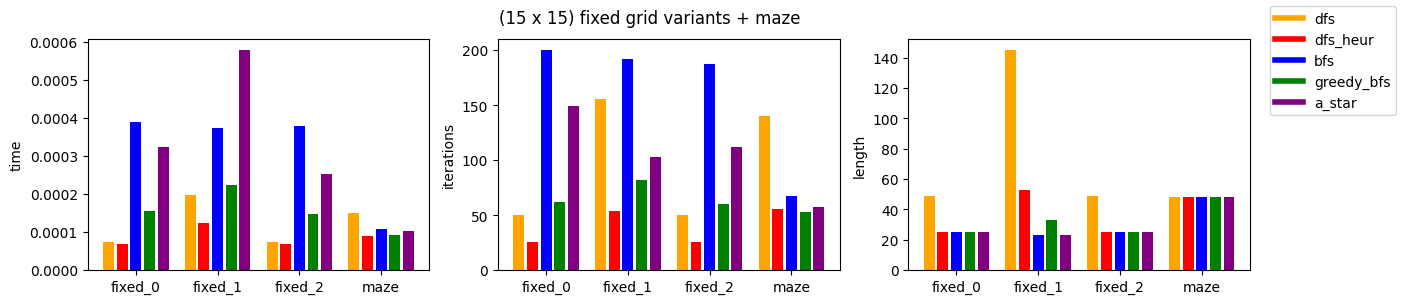

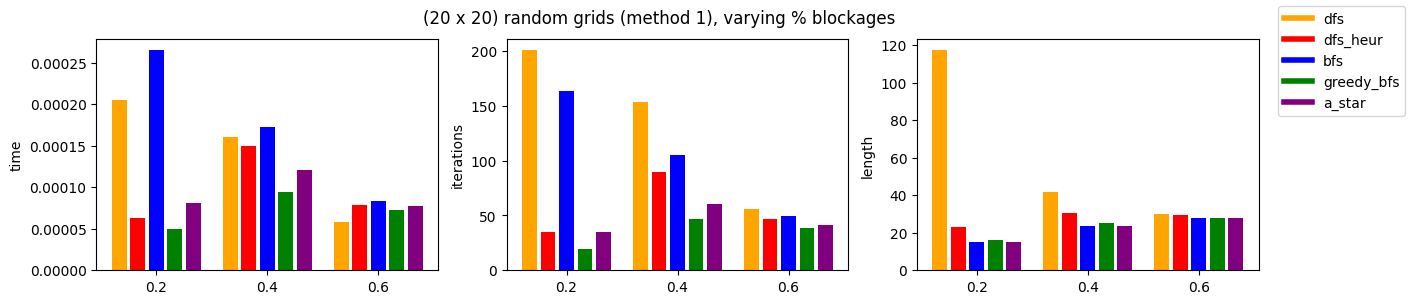

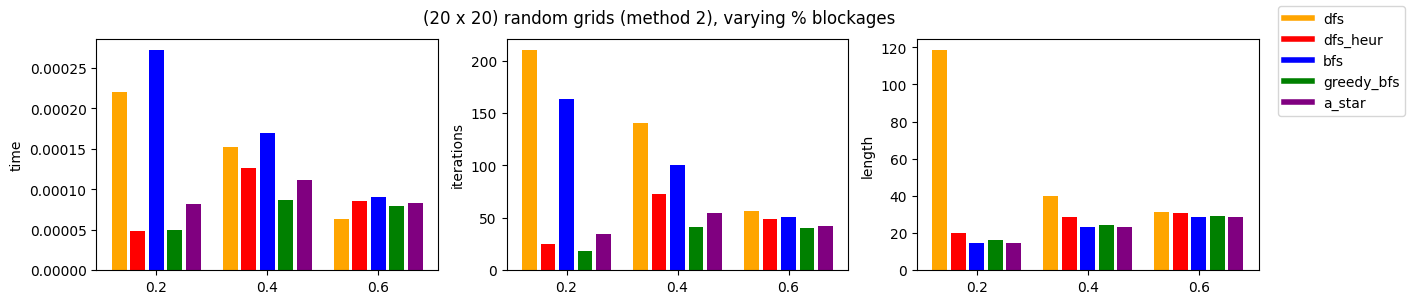

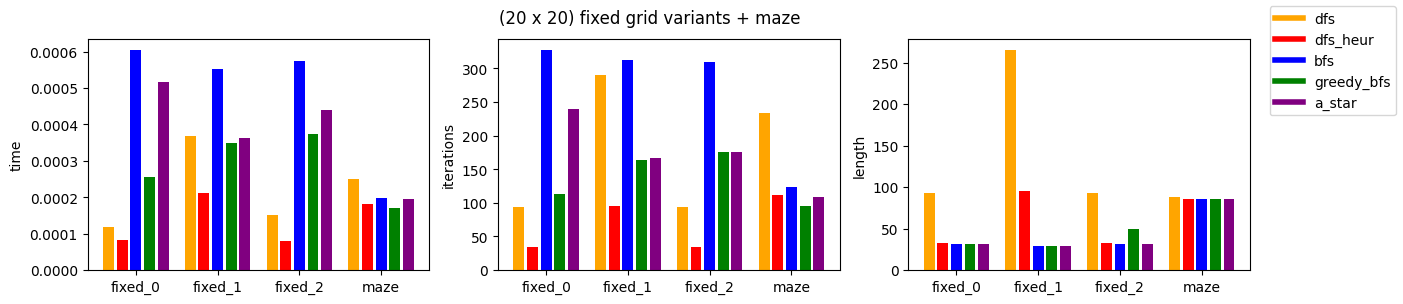

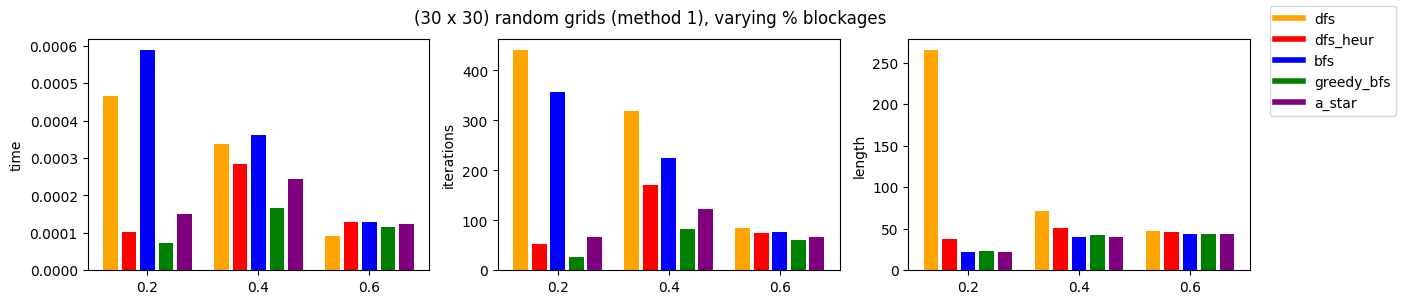

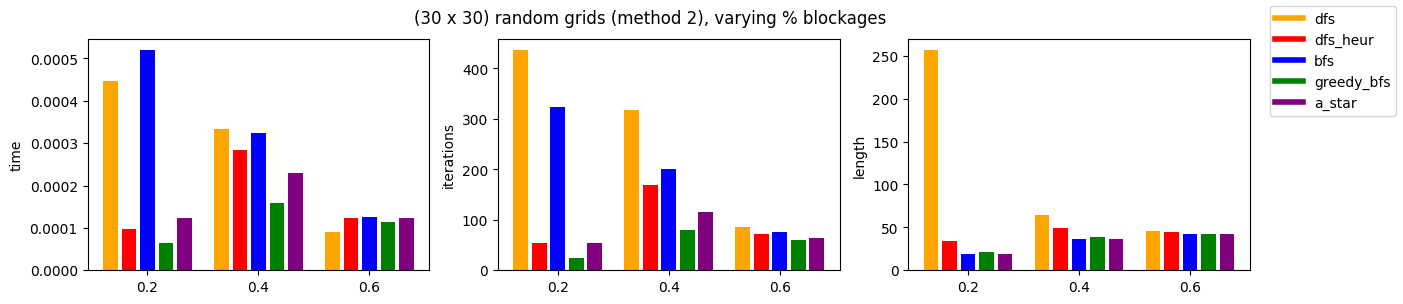

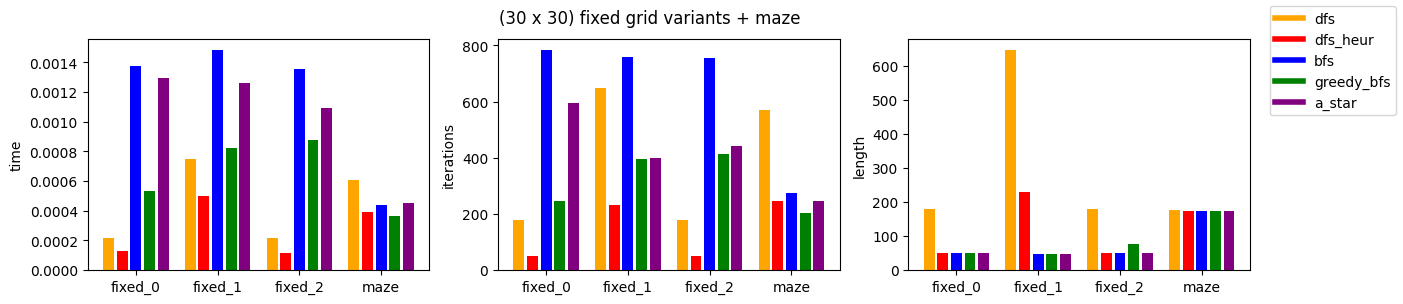

In [243]:
colors = {
    "bfs": "blue",
    "greedy_bfs": "green",
    "dfs": "orange",
    "dfs_heur": "red",
    "a_star": "purple"
}

partition = df.xs("random", level=1).xs((10,10), level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("(10 x 10) random grids (method 1), varying % blockages")
plt.show()

partition = df.xs("random-1", level=1).xs((10,10), level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("(10 x 10) random grids (method 2), varying % blockages")
plt.show()

partition = df.xs(0, level=0).xs((10,10), level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("(10 x 10) fixed grid variants + maze")
plt.show()

partition = df.xs("random", level=1).xs((15,15), level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("(15 x 15) random grids (method 1), varying % blockages")
plt.show()

partition = df.xs("random-1", level=1).xs((15,15), level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("(15 x 15) random grids (method 2), varying % blockages")
plt.show()

partition = df.xs(0, level=0).xs((15,15), level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("(15 x 15) fixed grid variants + maze")
plt.show()

partition = df.xs("random", level=1).xs((20,20), level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("(20 x 20) random grids (method 1), varying % blockages")
plt.show()

partition = df.xs("random-1", level=1).xs((20,20), level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("(20 x 20) random grids (method 2), varying % blockages")
plt.show()

partition = df.xs(0, level=0).xs((20,20), level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("(20 x 20) fixed grid variants + maze")
plt.show()

partition = df.xs("random", level=1).xs((30,30), level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("(30 x 30) random grids (method 1), varying % blockages")
plt.show()

partition = df.xs("random-1", level=1).xs((30,30), level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("(30 x 30) random grids (method 2), varying % blockages")
plt.show()

partition = df.xs(0, level=0).xs((30,30), level=1)
fig = bar_chart_performance(partition, colors, figsize=(15,3))
fig.suptitle("(30 x 30) fixed grid variants + maze")
plt.show()


## Let's see these in action on the fixed grid variants

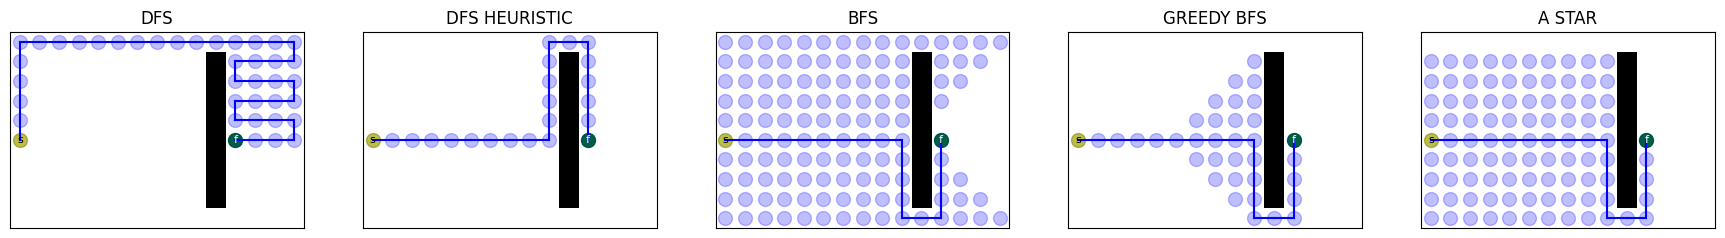

ORDER (fast to slow):
dfs_heuristic
greedy_bfs
dfs
a_star
bfs


In [80]:
graph = Graph(rows=10, cols=15)

graph.generate_grid(grid_type="fixed", variant=0)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

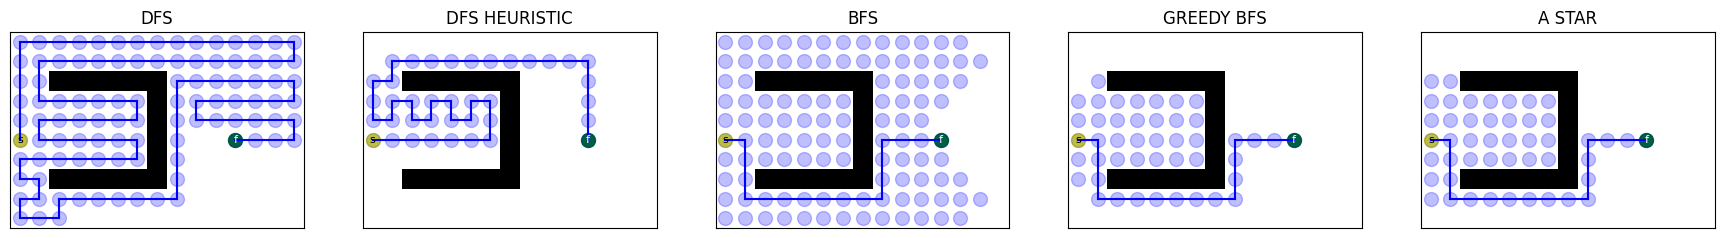

ORDER (fast to slow):
dfs_heuristic
greedy_bfs
a_star
dfs
bfs


In [81]:
graph = Graph(rows=10, cols=15)

graph.generate_grid(grid_type="fixed", variant=1)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

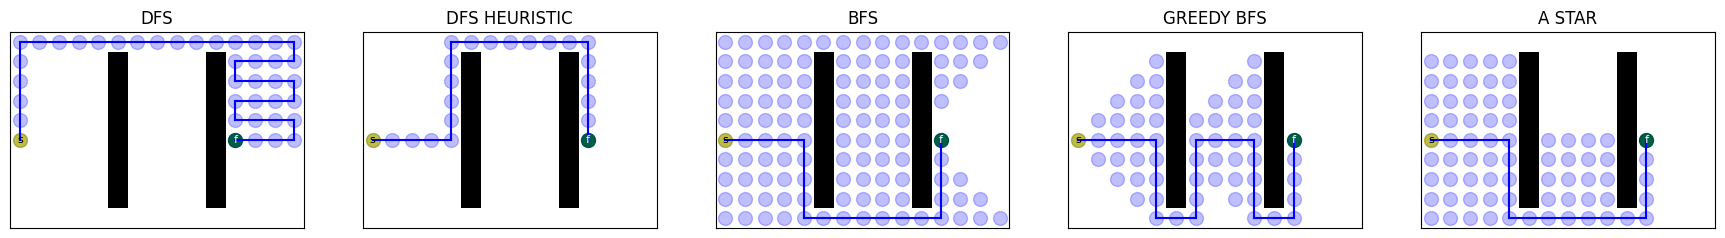

ORDER (fast to slow):
dfs_heuristic
dfs
greedy_bfs
a_star
bfs


In [82]:
graph = Graph(rows=10, cols=15)

graph.generate_grid(grid_type="fixed", variant=2)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

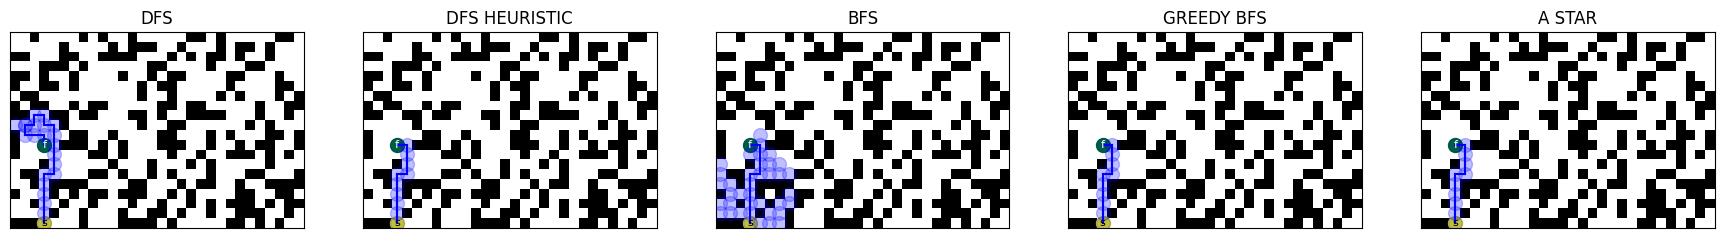

ORDER (fast to slow):
dfs_heuristic
greedy_bfs
a_star
dfs
bfs


In [83]:
graph = Graph(rows=20, cols=30)

graph.generate_grid(grid_type="random", percent_blocked=0.4)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

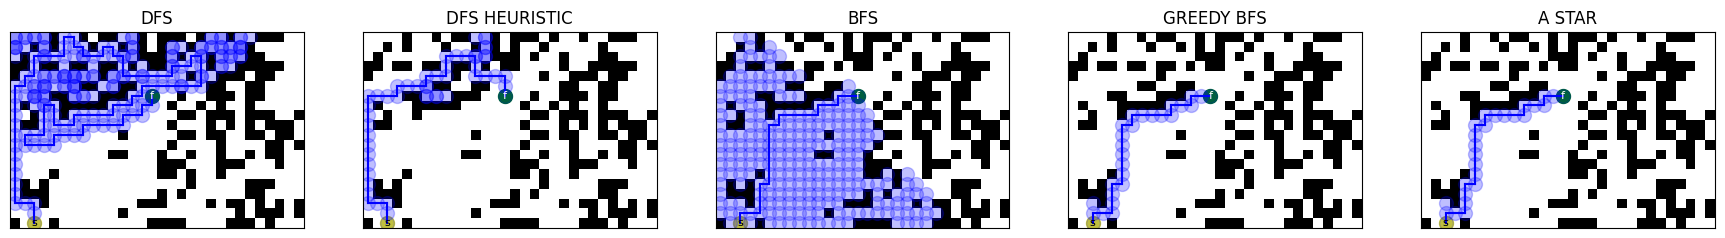

ORDER (fast to slow):
greedy_bfs
a_star
dfs_heuristic
dfs
bfs


In [84]:
graph = Graph(rows=20, cols=30)

graph.generate_grid(grid_type="random-1", percent_blocked=0.4)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

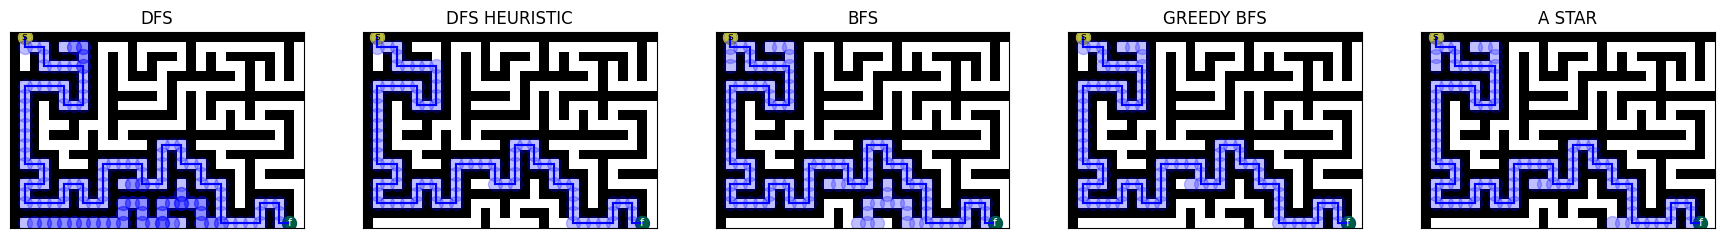

ORDER (fast to slow):
dfs_heuristic
greedy_bfs
a_star
bfs
dfs


In [244]:
graph = Graph(rows=20, cols=30)

graph.generate_grid(grid_type="maze")

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()